In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error as mse
import xgboost as xgb
from prophet import Prophet
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
import os

In [3]:
os.getcwd()

'C:\\Users\\Dell'

In [95]:
os.chdir(r'C:\Users\Dell\Desktop\Data Science\Projects\Master Thesis Project\predict-energy-behavior-of-prosumers')

In [96]:
consumption_df = pd.read_csv('consumptionOnly_features.csv')
production_df = pd.read_csv('productionOnly_features.csv')

In [6]:
consumption_df.head(2)

,datetime,installed_capacity,eic_count,forecasted_lowest_gas_price_per_mwh,forecasted_highest_gas_price_per_mwh,forecasted_electric_price_mwh,temperature,dewpoint,rain,snowfall,...,datetime_month,datetime_year,datetime_day_of_week,datetime_weekend,datetime_hour_cosine,datetime_hour_sin,datetime_month_cosine,datetime_month_sin,datetime_day_of_week_cosine,datetime_day_of_week_sin
0,2021-09-01 00:00:00,70659.26,7.0,45.62,46.29,96.99,13.308929,10.987500,0.013393,0.0,...,9,2021,2,0,1.000000,0.000000,-1.836970e-16,-1.0,-0.5,0.866025
1,2021-09-01 01:00:00,70659.26,37.0,45.62,46.29,94.77,13.211607,10.875893,0.005357,0.0,...,9,2021,2,0,0.962917,0.269797,-1.836970e-16,-1.0,-0.5,0.866025


In [110]:
consumption_df = consumption_df.fillna(method = 'bfill')
consumption_df = consumption_df.fillna(method = 'ffill')
production_df= production_df.fillna(method = 'bfill')
production_df= production_df.fillna(method = 'ffill')

In [6]:
production_df.isna().sum()

datetime                                0
installed_capacity                      0
eic_count                               0
forecasted_highest_gas_price_per_mwh    0
temperature                             0
dewpoint                                0
rain                                    0
snowfall                                0
surface_pressure                        0
cloudcover_total                        0
cloudcover_low                          0
cloudcover_mid                          0
cloudcover_high                         0
windspeed_10m                           0
winddirection_10m                       0
shortwave_radiation                     0
direct_solar_radiation                  0
diffuse_radiation                       0
latitude                                0
longitude                               0
target                                  0
total_radiation                         0
solar_radiation_ratio                   0
solar_radiation_product           

In [8]:
consumption_df_original = consumption_df.copy()
production_df_original = production_df.copy()

In [9]:
consumption_df_original.head(2)

,datetime,installed_capacity,eic_count,forecasted_lowest_gas_price_per_mwh,forecasted_highest_gas_price_per_mwh,forecasted_electric_price_mwh,temperature,dewpoint,rain,snowfall,...,datetime_month,datetime_year,datetime_day_of_week,datetime_weekend,datetime_hour_cosine,datetime_hour_sin,datetime_month_cosine,datetime_month_sin,datetime_day_of_week_cosine,datetime_day_of_week_sin
0,2021-09-01 00:00:00,70659.26,7.0,45.62,46.29,96.99,13.308929,10.987500,0.013393,0.0,...,9,2021,2,0,1.000000,0.000000,-1.836970e-16,-1.0,-0.5,0.866025
1,2021-09-01 01:00:00,70659.26,37.0,45.62,46.29,94.77,13.211607,10.875893,0.005357,0.0,...,9,2021,2,0,0.962917,0.269797,-1.836970e-16,-1.0,-0.5,0.866025


In [10]:
production_df_original.head(2)

,datetime,installed_capacity,eic_count,forecasted_highest_gas_price_per_mwh,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,...,datetime_hour_cosine,datetime_hour_sin,datetime_month_cosine,datetime_month_sin,datetime_day_of_week_cosine,datetime_day_of_week_sin,time_in_year,window_24,window_168,forecasted_average_gas_price_per_mwh
0,2021-09-01 00:00:00,70659.26,67.0,46.29,13.308929,10.987500,0.013393,0.0,1009.517857,48.294643,...,1.000000,0.000000,-1.836970e-16,-1.0,-0.5,0.866025,late_mid,4.362,4.362,71.305
1,2021-09-01 01:00:00,70659.26,31.0,46.29,13.211607,10.875893,0.005357,0.0,1009.345536,42.803571,...,0.962917,0.269797,-1.836970e-16,-1.0,-0.5,0.866025,late_mid,4.362,4.362,70.195


## Lasso Model

In [18]:
features = ['datetime', 'lag_1', 'lag_2', 'datetime_year', 'installed_capacity', 'datetime_month', 'installed_capacity_total_solar', 'solar_radiation_product', 'datetime_hour_cosine', 'lag_168', 'diffuse_radiation', 'window_24','lag_24', 'target']

In [17]:
production_df.columns

Index(['datetime', 'installed_capacity', 'eic_count',
       'forecasted_highest_gas_price_per_mwh', 'temperature', 'dewpoint',
       'rain', 'snowfall', 'surface_pressure', 'cloudcover_total',
       'cloudcover_low', 'cloudcover_mid', 'cloudcover_high', 'windspeed_10m',
       'winddirection_10m', 'shortwave_radiation', 'direct_solar_radiation',
       'diffuse_radiation', 'latitude', 'longitude', 'target',
       'total_radiation', 'solar_radiation_ratio', 'solar_radiation_product',
       'installed_capacity_total_solar', 'temperature_dewpoint', 'lag_1',
       'lag_2', 'lag_24', 'lag_168', 'datetime_hour', 'datetime_month',
       'datetime_year', 'datetime_day_of_week', 'datetime_weekend',
       'datetime_hour_cosine', 'datetime_hour_sin', 'datetime_month_cosine',
       'datetime_month_sin', 'datetime_day_of_week_cosine',
       'datetime_day_of_week_sin', 'time_in_year', 'window_24', 'window_168',
       'forecasted_average_gas_price_per_mwh'],
      dtype='object')

In [36]:
production_df = production_df_original
temp= production_df[features]
lasso_train = production_df[features][:int(len(production_df)* 0.8)]
lasso_test = production_df[features][int(len(production_df)* 0.8):]
lasso_train.set_index('datetime', inplace = True)
lasso_test.set_index('datetime', inplace = True)

In [37]:
lasso_X_train = lasso_train.drop(columns = 'target', axis = 1)
lasso_y_train = lasso_train['target']
lasso_X_test = lasso_test.drop(columns = 'target', axis = 1)
lasso_y_test = lasso_test['target']

In [39]:
def lassoModel(X, y):
    tscv = TimeSeriesSplit(n_splits=3)  # Adjust the number of splits as needed
    selected_features = []
    scores = []    
    for train_index, test_index in tscv.split(X,y):
    # Split the data into training and testing sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Standardize the features (important for regularized models)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
     # Instantiate the Lasso model
        alpha = 0.01  # Adjust the regularization strength
        model = Lasso(alpha=alpha)
       

        # Fit the Lasso model
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test)
        score = mse(y_test, y_pred)
        scores.append(score)

    return np.sqrt(np.mean(scores)), model

In [40]:
lasso_model_score, lasso_model = lassoModel(lasso_X_train, lasso_y_train)

In [42]:
lasso_model.predict(lasso_X_test)

array([2.23064375e+07, 2.41925348e+07, 2.26445845e+07, ...,
       3.53920193e+10, 2.42799232e+07, 4.10027278e+07])

In [41]:
lasso_model_score

1009720450348.7806

In [43]:
def lassoModelTest(X_test, y_test):
    score, model = lassoModel(lasso_X_train, lasso_y_train)      
    scaler = StandardScaler()
    X_test_scaled = scaler.fit_transform(X_test)
    test_pred = model.predict(X_test_scaled)
    modelScore = mse(y_test, test_pred)
    return modelScore, test_pred

In [44]:
score, lasso_predictions = lassoModelTest(lasso_X_test, lasso_y_test)

In [46]:
def plotForecast(test_set,y_test, predictions):    
    plt.figure(figsize=(15,7))
    plt.plot(test_set.index, predictions, label = 'Prediction')
    plt.plot(test_set.index, y_test, label ='Actuals')
    plt.show()

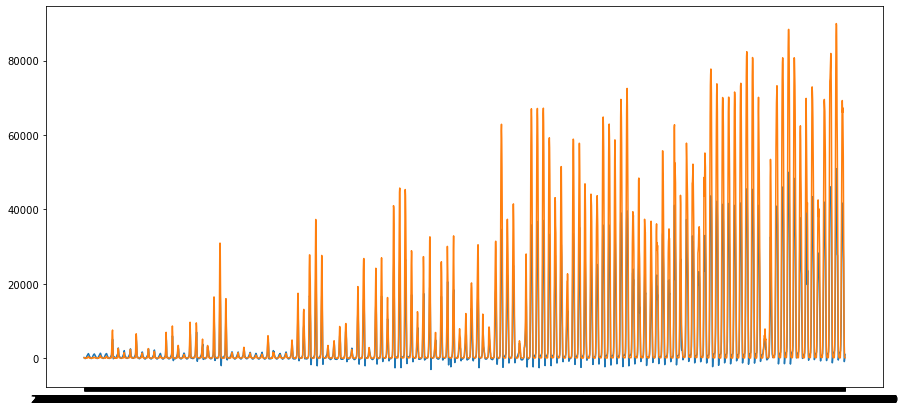

In [47]:
plotForecast(lasso_X_test, lasso_y_test, lasso_predictions)

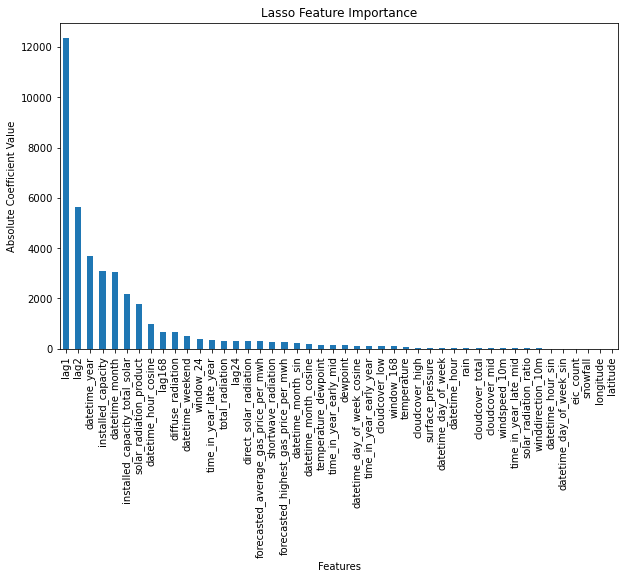

In [56]:
feature_importance = pd.Series(lasso_model.coef_, index=X.columns)

# Sort features by absolute coefficient values for better visualization
sorted_feature_importance = feature_importance.abs().sort_values(ascending=False)

# Plotting the bar plot
plt.figure(figsize=(10, 6))
sorted_feature_importance.plot(kind='bar')
plt.title('Lasso Feature Importance')
plt.xlabel('Features')
plt.ylabel('Absolute Coefficient Value')
plt.show()

### XGBoost Model

In [263]:
# Adjust the number of splits as needed
def xgbModel():
    df = df_original
    train = df.reset_index()[:int(len(df)* 0.6)]
    validation = df.reset_index()[int(len(df)*0.6) :int(len(df)*0.8)]
    test = df.reset_index()[int(len(df)* 0.8):]
    train=train.set_index('datetime')
    validation = validation.set_index('datetime')
    test= test.set_index('datetime')
    
    X_train= train.drop(columns = ['target', 'log_target'], axis = 1)
    y_train = train['target']
    X_val = validation.drop(columns = ['target', 'log_target'], axis = 1)
    y_val = validation['target']
    
    model = xgb.XGBRegressor(n_estimators= 800,
                          early_stopping_rounds = 50,
                          learning_rate = 0.010)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    model.fit(X_train_scaled, y_train,
           eval_set=[(X_train_scaled, y_train), (X_val_scaled, y_val)],
           verbose = True)
    return model
    
    

In [265]:
xgbmodel = xgbModel()

[0]	validation_0-rmse:9718.44578	validation_1-rmse:11075.42052
[1]	validation_0-rmse:9625.50445	validation_1-rmse:10982.51290
[2]	validation_0-rmse:9533.48702	validation_1-rmse:10890.27511
[3]	validation_0-rmse:9442.40155	validation_1-rmse:10799.19112
[4]	validation_0-rmse:9352.20238	validation_1-rmse:10709.04958
[5]	validation_0-rmse:9262.75867	validation_1-rmse:10620.86579
[6]	validation_0-rmse:9174.40798	validation_1-rmse:10532.55910
[7]	validation_0-rmse:9086.81914	validation_1-rmse:10446.04462
[8]	validation_0-rmse:9000.18098	validation_1-rmse:10360.08961
[9]	validation_0-rmse:8914.31420	validation_1-rmse:10275.48192
[10]	validation_0-rmse:8829.29557	validation_1-rmse:10189.99942
[11]	validation_0-rmse:8745.17288	validation_1-rmse:10106.11046
[12]	validation_0-rmse:8661.81256	validation_1-rmse:10024.42874
[13]	validation_0-rmse:8579.36109	validation_1-rmse:9941.19988
[14]	validation_0-rmse:8497.80491	validation_1-rmse:9860.56861
[15]	validation_0-rmse:8416.88554	validation_1-rmse:

In [270]:
df_original.head()

,datetime,installed_capacity,eic_count,forecasted_highest_gas_price_per_mwh,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,...,datetime_day_of_week_cosine,datetime_day_of_week_sin,window_24,window_168,log_target,forecasted_average_gas_price_per_mwh,time_in_year_early_mid,time_in_year_early_year,time_in_year_late_mid,time_in_year_late_year
0,2021-09-01 00:00:00,141318.52,7.0,46.29,13.308929,10.987500,0.013393,0.0,1009.517857,48.294643,...,-0.5,0.866025,19864.170000,19864.170000,9.896673,71.305,0,0,1,0
1,2021-09-01 01:00:00,141318.52,31.0,46.29,13.211607,10.875893,0.005357,0.0,1009.345536,42.803571,...,-0.5,0.866025,19864.170000,19864.170000,9.866664,70.195,0,0,1,0
2,2021-09-01 02:00:00,141318.52,67.0,46.29,13.109821,10.759821,0.001786,0.0,1008.944643,35.312500,...,-0.5,0.866025,19570.550000,19570.550000,9.865928,69.750,0,0,1,0
3,2021-09-01 03:00:00,141318.52,89.0,46.29,12.985714,10.575893,0.000000,0.0,1008.779464,33.491071,...,-0.5,0.866025,19467.945667,19467.945667,9.853667,68.935,0,0,1,0
4,2021-09-01 04:00:00,141318.52,61.0,46.29,12.863393,10.410714,0.000000,0.0,1008.670536,29.973214,...,-0.5,0.866025,19357.959500,19357.959500,9.871461,68.725,0,0,1,0


In [127]:
def xgbPredictions():
    xgbmodel = xgbModel()
    df = df_original        
    test = df.reset_index()[int(len(df)* 0.8):]       
    test= test.set_index('datetime')    
    X_test = test.drop(columns = ['target', 'log_target'], axis = 1)
    y_test = test['target']
    X_test_scaled = scaler.fit_transform(X_test)
    test_predictions = xgbmodel.predict(X_test_scaled)
    modelScore = np.sqrt(mse(y_test, test_predictions))
    return test_predictions, modelScore

In [280]:
xgbpredictions, xgbTestScore = xgbPredictions()

[0]	validation_0-rmse:9718.44578	validation_1-rmse:11075.42052
[1]	validation_0-rmse:9625.50445	validation_1-rmse:10982.51290
[2]	validation_0-rmse:9533.48702	validation_1-rmse:10890.27511
[3]	validation_0-rmse:9442.40155	validation_1-rmse:10799.19112
[4]	validation_0-rmse:9352.20238	validation_1-rmse:10709.04958
[5]	validation_0-rmse:9262.75867	validation_1-rmse:10620.86579
[6]	validation_0-rmse:9174.40798	validation_1-rmse:10532.55910
[7]	validation_0-rmse:9086.81914	validation_1-rmse:10446.04462
[8]	validation_0-rmse:9000.18098	validation_1-rmse:10360.08961
[9]	validation_0-rmse:8914.31420	validation_1-rmse:10275.48192
[10]	validation_0-rmse:8829.29557	validation_1-rmse:10189.99942
[11]	validation_0-rmse:8745.17288	validation_1-rmse:10106.11046
[12]	validation_0-rmse:8661.81256	validation_1-rmse:10024.42874
[13]	validation_0-rmse:8579.36109	validation_1-rmse:9941.19988
[14]	validation_0-rmse:8497.80491	validation_1-rmse:9860.56861
[15]	validation_0-rmse:8416.88554	validation_1-rmse:

In [279]:
xgbTestScore

13036.873144326653

In [281]:
df = df_original        
test = df.reset_index()[int(len(df)* 0.8):]       
test= test.set_index('datetime')    
X_test = test.drop(columns = ['target', 'log_target'], axis = 1)
y_test = test['target']

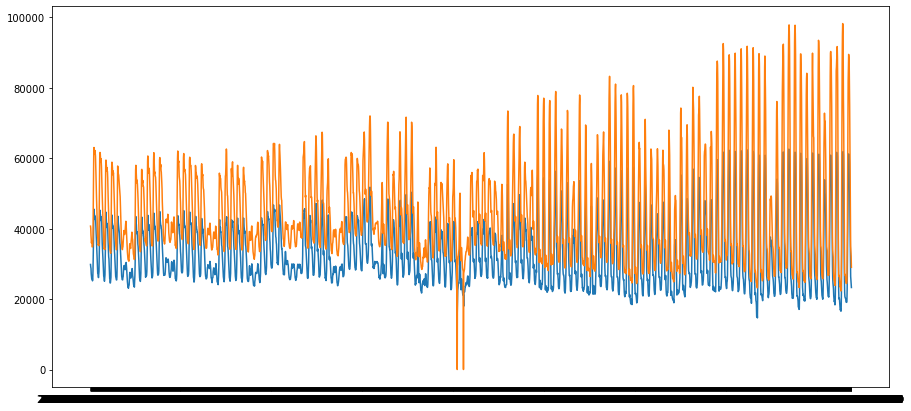

In [282]:
plt.figure(figsize=(15,7))
plt.plot(X_test.index, xgbpredictions, label = 'Prediction')
plt.plot(X_test.index, y_test, label ='Actuals')
plt.show()

### Facebook Prophet Modeling: Total Energy Produced by Prosumers

In [111]:
production_df.head(2)

,datetime,installed_capacity,eic_count,forecasted_highest_gas_price_per_mwh,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,...,datetime_hour_cosine,datetime_hour_sin,datetime_month_cosine,datetime_month_sin,datetime_day_of_week_cosine,datetime_day_of_week_sin,time_in_year,window_24,window_168,forecasted_average_gas_price_per_mwh
0,2021-09-01 00:00:00,70659.26,67.0,46.29,13.308929,10.987500,0.013393,0.0,1009.517857,48.294643,...,1.000000,0.000000,-1.836970e-16,-1.0,-0.5,0.866025,late_mid,4.362,4.362,71.305
1,2021-09-01 01:00:00,70659.26,31.0,46.29,13.211607,10.875893,0.005357,0.0,1009.345536,42.803571,...,0.962917,0.269797,-1.836970e-16,-1.0,-0.5,0.866025,late_mid,4.362,4.362,70.195


<AxesSubplot:>

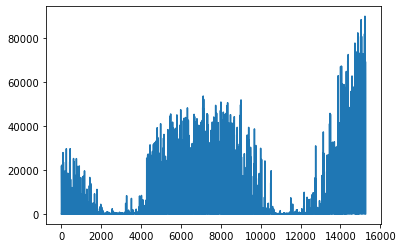

In [98]:
production_df['target'].plot()

In [16]:
production_df.columns[20:]

Index(['target', 'total_radiation', 'solar_radiation_ratio',
       'solar_radiation_product', 'installed_capacity_total_solar',
       'temperature_dewpoint', 'lag_1', 'lag_2', 'lag_24', 'lag_168',
       'datetime_hour', 'datetime_month', 'datetime_year',
       'datetime_day_of_week', 'datetime_weekend', 'datetime_hour_cosine',
       'datetime_hour_sin', 'datetime_month_cosine', 'datetime_month_sin',
       'datetime_day_of_week_cosine', 'datetime_day_of_week_sin',
       'time_in_year', 'window_24', 'window_168',
       'forecasted_average_gas_price_per_mwh'],
      dtype='object')

In [112]:
p_train = production_df[:int(len(production_df)* 0.7)]
p_test = production_df[int(len(production_df)* 0.7):]

In [113]:
p_train['datetime'].max(), p_train['datetime'].min()

('2022-11-20 03:00:00', '2021-09-01 00:00:00')

In [101]:
p_test['datetime'].max(), p_test['datetime'].min()

('2023-05-29 23:00:00', '2022-11-20 04:00:00')

In [114]:
p_test.head()

,datetime,installed_capacity,eic_count,forecasted_highest_gas_price_per_mwh,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,...,datetime_hour_cosine,datetime_hour_sin,datetime_month_cosine,datetime_month_sin,datetime_day_of_week_cosine,datetime_day_of_week_sin,time_in_year,window_24,window_168,forecasted_average_gas_price_per_mwh
10684,2022-11-20 04:00:00,108265.27,14.0,131.37,-2.960714,-5.728571,0.000000,0.227500,1011.716964,99.678571,...,0.460065,0.887885,0.866025,-0.5,1.0,-2.449294e-16,late_year,228.640250,826.250018,148.000
10685,2022-11-20 05:00:00,108265.27,55.0,131.37,-2.986607,-5.655357,0.000893,0.241875,1011.333929,99.258929,...,0.203456,0.979084,0.866025,-0.5,1.0,-2.449294e-16,late_year,225.476625,825.934339,197.030
10686,2022-11-20 06:00:00,108265.27,16.0,131.37,-2.975000,-5.578571,0.001786,0.250625,1010.975893,99.160714,...,-0.068242,0.997669,0.866025,-0.5,1.0,-2.449294e-16,late_year,224.358917,825.771071,222.975
10687,2022-11-20 07:00:00,108265.27,43.0,131.37,-2.991964,-5.518750,0.000893,0.231875,1010.669643,98.839286,...,-0.334880,0.942261,0.866025,-0.5,1.0,-2.449294e-16,late_year,224.028792,825.719738,216.470
10688,2022-11-20 08:00:00,108265.27,20.0,131.37,-2.987500,-5.483036,0.001786,0.196875,1010.579464,98.857143,...,-0.576680,0.816970,0.866025,-0.5,1.0,-2.449294e-16,late_year,221.920167,825.551815,220.025


In [103]:
p_test[['target', 'lag_1']]

,target,lag_1
10684,66.998,140.267
10685,78.978,66.998
10686,101.608,78.978
10687,76.252,101.608
10688,106.317,76.252
...,...,...
15259,10806.911,26871.611
15260,3406.545,10806.911
15261,589.922,3406.545
15262,174.229,589.922


In [115]:
# Preparing the dataset for prophet

p_train= p_train[['datetime','target', 'installed_capacity_total_solar', 'lag_1']]
p_test = p_test[['datetime','target', 'installed_capacity_total_solar', 'lag_1']]

In [116]:
names = {'datetime':'ds',
'target': 'y'}

p_train = p_train.rename(columns = names)
p_test = p_test.rename(columns = names)

In [117]:
p_test.head()

,ds,y,installed_capacity_total_solar,lag_1
10684,2022-11-20 04:00:00,66.998,1.376447e+06,140.267
10685,2022-11-20 05:00:00,78.978,1.319276e+06,66.998
10686,2022-11-20 06:00:00,101.608,1.002904e+06,78.978
10687,2022-11-20 07:00:00,76.252,6.855132e+05,101.608
10688,2022-11-20 08:00:00,106.317,2.861124e+05,76.252


In [108]:
p_train.head(2)

,ds,y,installed_capacity_total_solar,lag_1
0,2021-09-01 00:00:00,4.362,484182.665223,NaN
1,2021-09-01 01:00:00,11.852,222071.960000,4.362


In [118]:
%%time
prophetModel = Prophet(growth = 'linear', seasonality_mode = 'multiplicative', weekly_seasonality= True, interval_width = 0.95)
prophetModel.add_seasonality(name='hourly', period=24, fourier_order=5)
prophetModel.add_seasonality(name='monthly', period=30.5, fourier_order=5)
prophetModel.add_seasonality(name='daily', period=1, fourier_order=5)
prophetModel.add_regressor('lag_1')
prophetModel.add_regressor('installed_capacity_total_solar')

prophetModel.fit(p_train)

11:04:32 - cmdstanpy - INFO - Chain [1] start processing
11:04:41 - cmdstanpy - INFO - Chain [1] done processing


Wall time: 10.3 s


### Predicting on the validation set

In [121]:
prod_prediction_test = prophetModel.predict(p_test)

In [122]:
prod_prediction_test.head(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,extra_regressors_multiplicative,...,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2022-11-20 04:00:00,5694.248912,-2276.568684,4165.162036,5694.248912,5694.248912,-0.022039,-0.022039,-0.022039,-0.943823,...,-0.852217,-0.852217,-0.852217,0.079478,0.079478,0.079478,0.0,0.0,0.0,841.515396
1,2022-11-20 05:00:00,5694.239369,-2735.627490,4166.737791,5694.239369,5694.239369,-0.020784,-0.020784,-0.020784,-0.953322,...,-0.861667,-0.861667,-0.861667,0.078157,0.078157,0.078157,0.0,0.0,0.0,787.700193
2,2022-11-20 06:00:00,5694.229826,-2380.858640,4268.161833,5694.229826,5694.229826,0.012359,0.012359,0.012359,-0.951882,...,-0.828708,-0.828708,-0.828708,0.076446,0.076446,0.076446,0.0,0.0,0.0,975.373832


In [123]:
prod_prediction_test[["yhat"]]

,yhat
0,841.515396
1,787.700193
2,975.373832
3,1887.409394
4,3548.939236
...,...
4575,20444.529616
4576,7653.630560
4577,2053.109595
4578,105.945145


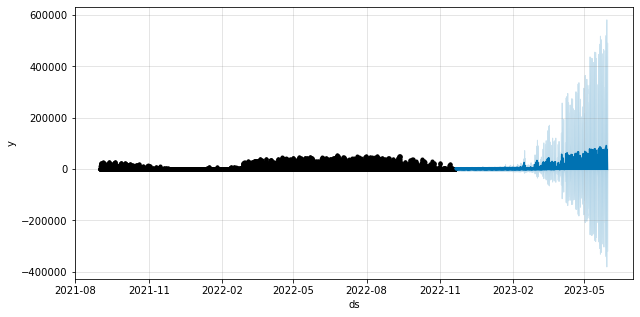

In [23]:
fig, ax = plt.subplots(figsize = (10,5))
fig = prophetModel.plot(prediction_test, ax = ax)
plt.show()

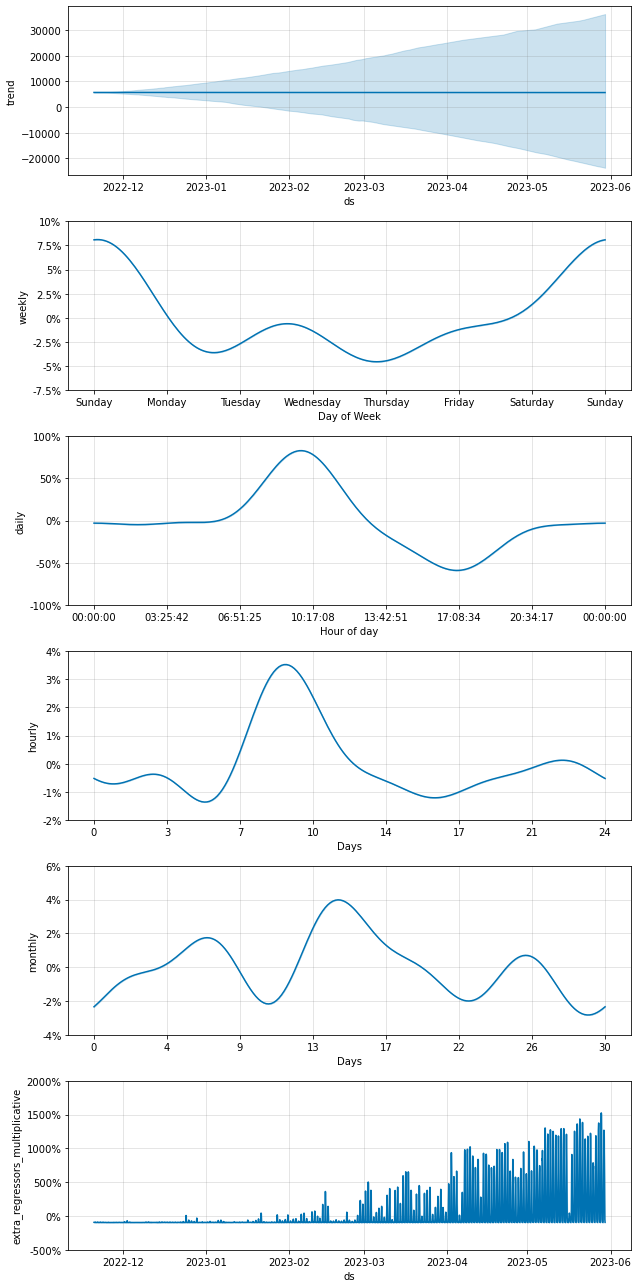

In [24]:
fig = prophetModel.plot_components(prediction_test)
plt.savefig("decomenergyprod.png")
plt.show()

#### Comparing Forecast to Actuals

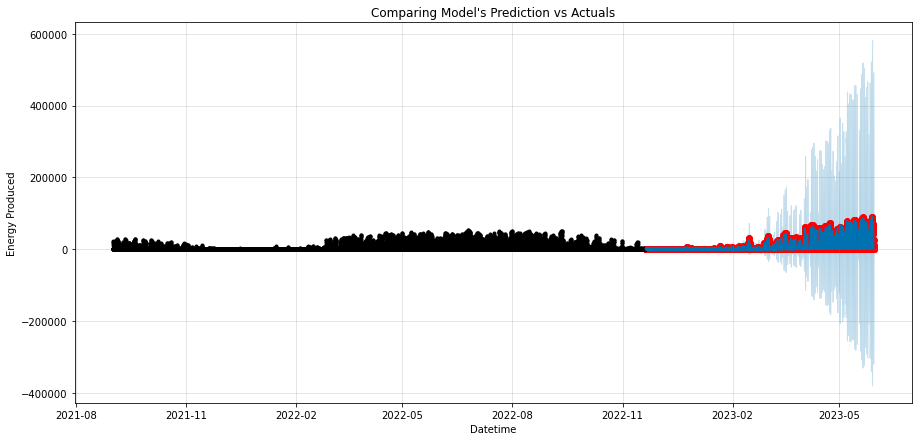

In [27]:
fig, ax = plt.subplots(figsize = (15,7))
fig = prophetModel.plot(prediction_test, ax = ax)
ax.scatter(p_test.ds, p_test['y'], color = 'r')
plt.title("Comparing Model's Prediction vs Actuals")
plt.ylabel("Energy Produced")
plt.xlabel("Datetime")
plt.savefig("prediction_vs_actuals.png")
plt.show()

#### Evaluating error using mean squared error on the validation set

In [226]:
evaluationScore = np.sqrt(mse(y_true = p_test['y'],
                                            y_pred = prediction_test['yhat']))
print(evaluationScore)

3056.8817267584905


### Facebook Prophet Modeling: Total Energy Consumed by Prosumers

In [29]:
consumption_df.head(2)

,datetime,installed_capacity,eic_count,forecasted_lowest_gas_price_per_mwh,forecasted_highest_gas_price_per_mwh,forecasted_electric_price_mwh,temperature,dewpoint,rain,snowfall,...,datetime_month,datetime_year,datetime_day_of_week,datetime_weekend,datetime_hour_cosine,datetime_hour_sin,datetime_month_cosine,datetime_month_sin,datetime_day_of_week_cosine,datetime_day_of_week_sin
0,2021-09-01 00:00:00,70659.26,7.0,45.62,46.29,96.99,13.308929,10.987500,0.013393,0.0,...,9,2021,2,0,1.000000,0.000000,-1.836970e-16,-1.0,-0.5,0.866025
1,2021-09-01 01:00:00,70659.26,37.0,45.62,46.29,94.77,13.211607,10.875893,0.005357,0.0,...,9,2021,2,0,0.962917,0.269797,-1.836970e-16,-1.0,-0.5,0.866025


In [63]:
int(len(consumption_df)* 0.7)

10684

In [69]:
consumption_train = consumption_df.reset_index()[0:10684]
consumption_test = consumption_df.reset_index()[10684:]

In [70]:
len(consumption_train), len(consumption_test)


(10684, 4580)

In [71]:
features=['datetime', 'target', 'lag_1', 'lag_2']
consumption_train= consumption_train[features]
consumption_test=consumption_test[features]

In [72]:
consumption_train['datetime'].min()

'2021-09-01 00:00:00'

In [73]:
consumption_test['datetime'].min()

'2022-11-20 04:00:00'

In [74]:
names = {'datetime':'ds',
'target': 'y'}
consumption_train.rename(columns = names, inplace = True)
consumption_test.rename(columns = names, inplace = True)

In [79]:
consumption_train.head(2)

,ds,y,lag_1,lag_2
0,2021-09-01 00:00:00,19859.808,19859.808,19859.808
1,2021-09-01 01:00:00,19265.078,19859.808,19859.808


In [76]:
%%time
prophetModel = Prophet(growth = 'linear', seasonality_mode = 'multiplicative',weekly_seasonality=True, interval_width = 0.95)
prophetModel.add_seasonality(name='hourly', period=24, fourier_order=5)
prophetModel.add_seasonality(name='monthly', period=30.5, fourier_order=5)
prophetModel.add_seasonality(name='daily', period=1, fourier_order=5)
prophetModel.add_regressor('lag_1')
prophetModel.add_regressor('lag_2')

prophetModel.fit(consumption_train)

14:41:49 - cmdstanpy - INFO - Chain [1] start processing
14:41:54 - cmdstanpy - INFO - Chain [1] done processing


Wall time: 5.95 s


In [89]:
con_prediction_test = prophetModel.predict(consumption_test)

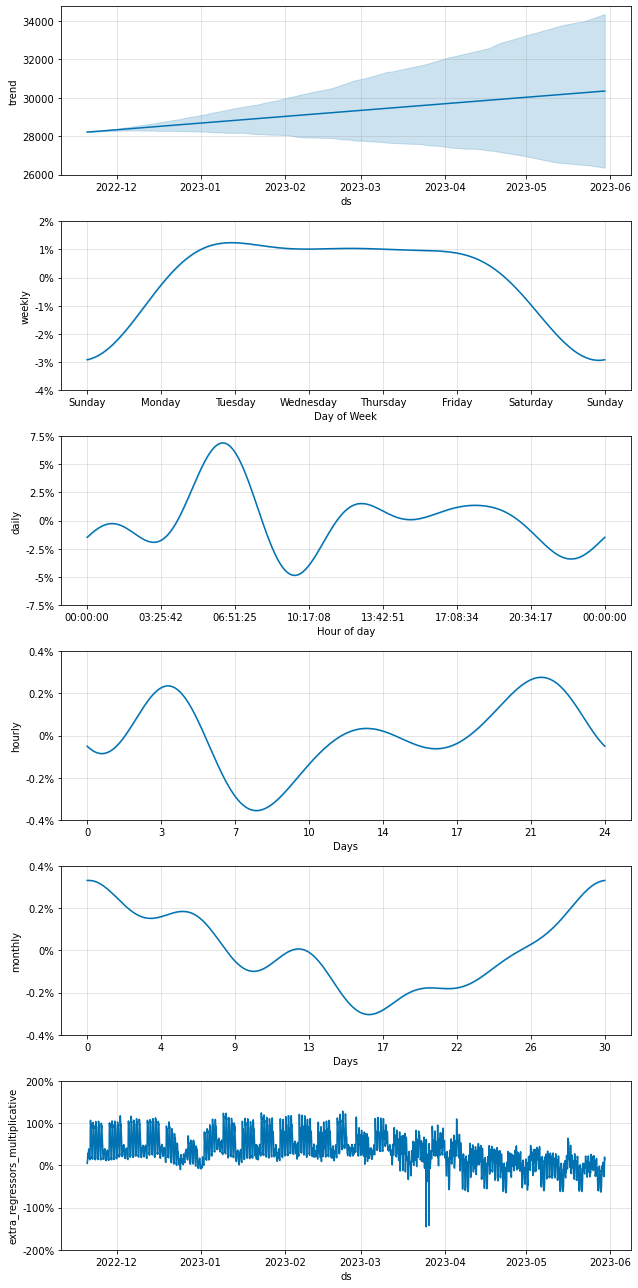

In [90]:
fig = prophetModel.plot_components(con_prediction_test)
plt.savefig("decomenergyconsumed.png")
plt.show()

In [91]:
con_prediction_test[["yhat", "ds"]]

,yhat,ds
0,28529.016992,2022-11-20 04:00:00
1,30508.320672,2022-11-20 05:00:00
2,31878.659927,2022-11-20 06:00:00
3,31827.039464,2022-11-20 07:00:00
4,33195.397580,2022-11-20 08:00:00
...,...,...
4575,28540.274587,2023-05-29 19:00:00
4576,34324.755860,2023-05-29 20:00:00
4577,36056.664535,2023-05-29 21:00:00
4578,35529.020206,2023-05-29 22:00:00


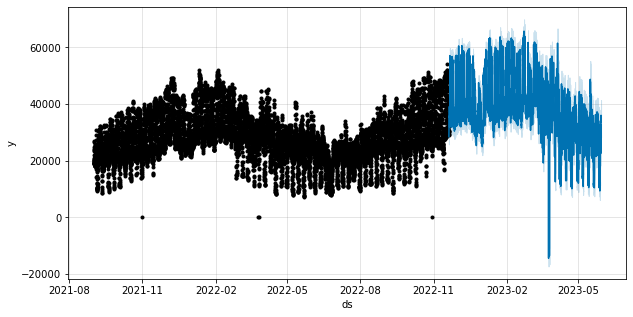

In [80]:
fig, ax = plt.subplots(figsize = (10,5))
fig = prophetModel.plot(prediction_test, ax = ax)
plt.show()

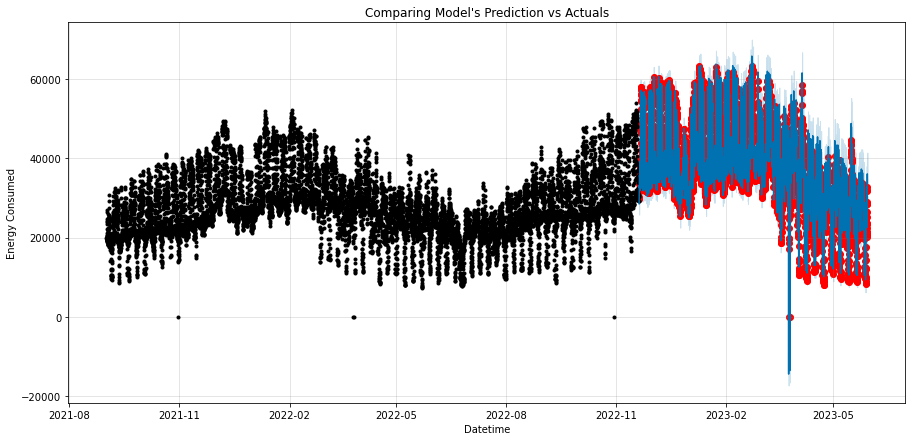

In [81]:
fig, ax = plt.subplots(figsize = (15,7))
fig = prophetModel.plot(prediction_test, ax = ax)
ax.scatter(consumption_test.ds, consumption_test['y'], color = 'r')
plt.title("Comparing Model's Prediction vs Actuals")
plt.ylabel("Energy Consumed")
plt.xlabel("Datetime")
plt.savefig("prediction_vs_actuals_consume.png")
plt.show()


In [82]:
evaluationScore = np.sqrt(mse(y_true = consumption_test['y'],
                                            y_pred = prediction_test['yhat']))
print(evaluationScore)

2468.8639930798463


## Deficit surplus

In [ ]:
df['New_Column'] = np.where(condition, 'Above 15', 'Below or Equal to 15')

In [142]:
def_surplus = prod_prediction_test[['ds']]
def_surplus['prod_prediction'] = prod_prediction_test['yhat']
def_surplus['con_prediction']= con_prediction_test['yhat']
def_surplus['deficit_surplus'] = def_surplus['prod_prediction'] - def_surplus['con_prediction']
condition = def_surplus['deficit_surplus']> 0
def_surplus['is_surplus'] = np.where(condition, 'surplus', 'deficit')
def_surplus.head()

,ds,prod_prediction,con_prediction,deficit_surplus,is_surplus
0,2022-11-20 04:00:00,841.515396,28529.016992,-27687.501596,deficit
1,2022-11-20 05:00:00,787.700193,30508.320672,-29720.620479,deficit
2,2022-11-20 06:00:00,975.373832,31878.659927,-30903.286095,deficit
3,2022-11-20 07:00:00,1887.409394,31827.039464,-29939.630070,deficit
4,2022-11-20 08:00:00,3548.939236,33195.397580,-29646.458344,deficit


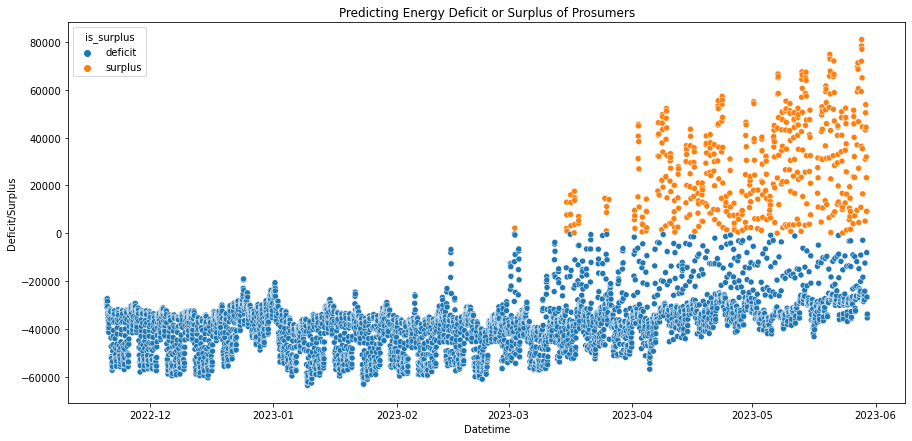

In [144]:
plt.figure(figsize=(15,7))
sns.scatterplot(x = 'ds', y = 'deficit_surplus', hue = 'is_surplus', data = def_surplus)
plt.title("Predicting Energy Deficit or Surplus of Prosumers")
plt.ylabel("Deficit/Surplus")
plt.xlabel("Datetime")
plt.savefig("deficit_surplus.png")
plt.show()

### LSTM 

In [225]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [110]:
# 1. Prepare data
# 2. Reshape data to suit the model input
# 3. import model tools needed
# 4. Structure the model and set parameters
# 5. Build the model
# 6. Split data in train validation test split
# 7. Fit model on train and train
# 8. Predict

In [226]:
df_original.head()

,datetime,installed_capacity,eic_count,forecasted_highest_gas_price_per_mwh,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,...,datetime_day_of_week_cosine,datetime_day_of_week_sin,window_24,window_168,log_target,forecasted_average_gas_price_per_mwh,time_in_year_early_mid,time_in_year_early_year,time_in_year_late_mid,time_in_year_late_year
0,2021-09-01 00:00:00,141318.52,7.0,46.29,13.308929,10.987500,0.013393,0.0,1009.517857,48.294643,...,-0.5,0.866025,19864.170000,19864.170000,9.896673,71.305,0,0,1,0
1,2021-09-01 01:00:00,141318.52,31.0,46.29,13.211607,10.875893,0.005357,0.0,1009.345536,42.803571,...,-0.5,0.866025,19864.170000,19864.170000,9.866664,70.195,0,0,1,0
2,2021-09-01 02:00:00,141318.52,67.0,46.29,13.109821,10.759821,0.001786,0.0,1008.944643,35.312500,...,-0.5,0.866025,19570.550000,19570.550000,9.865928,69.750,0,0,1,0
3,2021-09-01 03:00:00,141318.52,89.0,46.29,12.985714,10.575893,0.000000,0.0,1008.779464,33.491071,...,-0.5,0.866025,19467.945667,19467.945667,9.853667,68.935,0,0,1,0
4,2021-09-01 04:00:00,141318.52,61.0,46.29,12.863393,10.410714,0.000000,0.0,1008.670536,29.973214,...,-0.5,0.866025,19357.959500,19357.959500,9.871461,68.725,0,0,1,0


In [227]:
#1 
temp = df_original.reset_index()[['datetime', 'target']]

In [228]:
temp.head()

,datetime,target
0,2021-09-01 00:00:00,19864.170
1,2021-09-01 01:00:00,19276.930
2,2021-09-01 02:00:00,19262.737
3,2021-09-01 03:00:00,19028.001
4,2021-09-01 04:00:00,19369.616


In [229]:
#2 Function that prepares the data for the model
def df_to_X_y(df, window_size =5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [a for a in df_as_np[i: i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y).flatten()        

In [230]:
X, y = df_to_X_y(temp)

In [231]:
X[0]

array([['2021-09-01 00:00:00', 19864.17],
       ['2021-09-01 01:00:00', 19276.93],
       ['2021-09-01 02:00:00', 19262.737],
       ['2021-09-01 03:00:00', 19028.001],
       ['2021-09-01 04:00:00', 19369.616]], dtype=object)

In [325]:
y

array([20651.026, 24168.775, 27708.857, ..., 33320.726, 32113.961,
       29016.488])

In [ ]:
# Splitting the data into train validaton  test split

In [232]:
temp = df_original.reset_index()[['datetime', 'target']]
train = temp[:int(len(temp)* 0.6)]
validation = temp[int(len(temp)*0.6) :int(len(temp)*0.8)]
test = temp[int(len(temp)* 0.8):]
train=train.set_index('datetime')
validation = validation.set_index('datetime')
test= test.set_index('datetime')

In [233]:
train.shape

(9158, 1)

In [234]:
validation.shape

(3053, 1)

In [235]:
test.shape

(3053, 1)

In [236]:
X_train, y_train = df_to_X_y(train, 5)
X_val, y_val = df_to_X_y(validation, 5)
X_test, y_test = df_to_X_y(test, 5)

In [238]:
X_val.shape

(3048, 5, 1)

In [237]:
X_test.shape

(3048, 5, 1)

In [26]:
y_test.shape

(3048,)

In [239]:
## Building Model Structure
model1 = Sequential()
model1.add(InputLayer((5,1)))
model1.add(LSTM(64))
model1.add(Dense(16, 'relu'))
model1.add(Dense(1, 'linear'))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 17,953
Trainable params: 17,953
Non-trainable params: 0
_________________________________________________________________


In [240]:
## Creating checkpoint to save best model
cp = ModelCheckpoint('model1/', save_best_only = True)

In [241]:
## Compiling Model
model1.compile(loss = MeanSquaredError(), optimizer = Adam(learning_rate = 0.0002), metrics = [RootMeanSquaredError()])

In [242]:
model1.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 1000, callbacks = [cp])

Epoch 1/1000
282/287 [============================>.] - ETA: 0s - loss: 1160719360.0000 - root_mean_squared_error: 34069.3320

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 36ms/step - loss: 1160633984.0000 - root_mean_squared_error: 34068.0781 - val_loss: 1549099904.0000 - val_root_mean_squared_error: 39358.6055
Epoch 2/1000
281/287 [============================>.] - ETA: 0s - loss: 1159763200.0000 - root_mean_squared_error: 34055.2969

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 47ms/step - loss: 1160467584.0000 - root_mean_squared_error: 34065.6367 - val_loss: 1548888832.0000 - val_root_mean_squared_error: 39355.9258
Epoch 3/1000
284/287 [============================>.] - ETA: 0s - loss: 1160454528.0000 - root_mean_squared_error: 34065.4453

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 47ms/step - loss: 1160255360.0000 - root_mean_squared_error: 34062.5195 - val_loss: 1548604288.0000 - val_root_mean_squared_error: 39352.3086
Epoch 4/1000
287/287 [==============================] - ETA: 0s - loss: 1159977600.0000 - root_mean_squared_error: 34058.4453

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 46ms/step - loss: 1159977600.0000 - root_mean_squared_error: 34058.4453 - val_loss: 1548208896.0000 - val_root_mean_squared_error: 39347.2852
Epoch 5/1000
280/287 [============================>.] - ETA: 0s - loss: 1162013824.0000 - root_mean_squared_error: 34088.3242

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 11s 39ms/step - loss: 1159507072.0000 - root_mean_squared_error: 34051.5352 - val_loss: 1547510528.0000 - val_root_mean_squared_error: 39338.4102
Epoch 6/1000
278/287 [============================>.] - ETA: 0s - loss: 1160170496.0000 - root_mean_squared_error: 34061.2773

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 40ms/step - loss: 1158847104.0000 - root_mean_squared_error: 34041.8438 - val_loss: 1546682112.0000 - val_root_mean_squared_error: 39327.8789
Epoch 7/1000
285/287 [============================>.] - ETA: 0s - loss: 1157728896.0000 - root_mean_squared_error: 34025.4141

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 11s 39ms/step - loss: 1158100096.0000 - root_mean_squared_error: 34030.8711 - val_loss: 1545765120.0000 - val_root_mean_squared_error: 39316.2188
Epoch 8/1000
282/287 [============================>.] - ETA: 0s - loss: 1158522368.0000 - root_mean_squared_error: 34037.0742

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 41ms/step - loss: 1157279616.0000 - root_mean_squared_error: 34018.8125 - val_loss: 1544761216.0000 - val_root_mean_squared_error: 39303.4492
Epoch 9/1000
287/287 [==============================] - ETA: 0s - loss: 1156385792.0000 - root_mean_squared_error: 34005.6719

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 48ms/step - loss: 1156385792.0000 - root_mean_squared_error: 34005.6719 - val_loss: 1543673984.0000 - val_root_mean_squared_error: 39289.6172
Epoch 10/1000
283/287 [============================>.] - ETA: 0s - loss: 1154326272.0000 - root_mean_squared_error: 33975.3789

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 41ms/step - loss: 1155420032.0000 - root_mean_squared_error: 33991.4688 - val_loss: 1542503296.0000 - val_root_mean_squared_error: 39274.7148
Epoch 11/1000
284/287 [============================>.] - ETA: 0s - loss: 1155055744.0000 - root_mean_squared_error: 33986.1094

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 42ms/step - loss: 1154384512.0000 - root_mean_squared_error: 33976.2344 - val_loss: 1541253120.0000 - val_root_mean_squared_error: 39258.7969
Epoch 12/1000
283/287 [============================>.] - ETA: 0s - loss: 1152717824.0000 - root_mean_squared_error: 33951.6992

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 11s 40ms/step - loss: 1153284224.0000 - root_mean_squared_error: 33960.0391 - val_loss: 1539927552.0000 - val_root_mean_squared_error: 39241.9102
Epoch 13/1000
282/287 [============================>.] - ETA: 0s - loss: 1151506432.0000 - root_mean_squared_error: 33933.8555

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 11s 39ms/step - loss: 1152120448.0000 - root_mean_squared_error: 33942.8984 - val_loss: 1538528512.0000 - val_root_mean_squared_error: 39224.0820
Epoch 14/1000
285/287 [============================>.] - ETA: 0s - loss: 1150578944.0000 - root_mean_squared_error: 33920.1836

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 47ms/step - loss: 1150889856.0000 - root_mean_squared_error: 33924.7695 - val_loss: 1537053312.0000 - val_root_mean_squared_error: 39205.2695
Epoch 15/1000
286/287 [============================>.] - ETA: 0s - loss: 1149606656.0000 - root_mean_squared_error: 33905.8516

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 43ms/step - loss: 1149597696.0000 - root_mean_squared_error: 33905.7188 - val_loss: 1535505664.0000 - val_root_mean_squared_error: 39185.5273
Epoch 16/1000
285/287 [============================>.] - ETA: 0s - loss: 1147888256.0000 - root_mean_squared_error: 33880.5000

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 42ms/step - loss: 1148249088.0000 - root_mean_squared_error: 33885.8242 - val_loss: 1533893120.0000 - val_root_mean_squared_error: 39164.9492
Epoch 17/1000
280/287 [============================>.] - ETA: 0s - loss: 1147282816.0000 - root_mean_squared_error: 33871.5625

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 11s 40ms/step - loss: 1146839296.0000 - root_mean_squared_error: 33865.0156 - val_loss: 1532208256.0000 - val_root_mean_squared_error: 39143.4336
Epoch 18/1000
286/287 [============================>.] - ETA: 0s - loss: 1145357056.0000 - root_mean_squared_error: 33843.1250

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 41ms/step - loss: 1145372160.0000 - root_mean_squared_error: 33843.3477 - val_loss: 1530457216.0000 - val_root_mean_squared_error: 39121.0586
Epoch 19/1000
286/287 [============================>.] - ETA: 0s - loss: 1143921536.0000 - root_mean_squared_error: 33821.9102

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 44ms/step - loss: 1143847936.0000 - root_mean_squared_error: 33820.8203 - val_loss: 1528639232.0000 - val_root_mean_squared_error: 39097.8164
Epoch 20/1000
285/287 [============================>.] - ETA: 0s - loss: 1142173312.0000 - root_mean_squared_error: 33796.0547

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 11s 39ms/step - loss: 1142268416.0000 - root_mean_squared_error: 33797.4609 - val_loss: 1526756608.0000 - val_root_mean_squared_error: 39073.7344
Epoch 21/1000
284/287 [============================>.] - ETA: 0s - loss: 1141097600.0000 - root_mean_squared_error: 33780.1367

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 11s 40ms/step - loss: 1140629376.0000 - root_mean_squared_error: 33773.2031 - val_loss: 1524804096.0000 - val_root_mean_squared_error: 39048.7383
Epoch 22/1000
286/287 [============================>.] - ETA: 0s - loss: 1138924928.0000 - root_mean_squared_error: 33747.9609

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 47ms/step - loss: 1138934144.0000 - root_mean_squared_error: 33748.0977 - val_loss: 1522786816.0000 - val_root_mean_squared_error: 39022.9023
Epoch 23/1000
283/287 [============================>.] - ETA: 0s - loss: 1138182016.0000 - root_mean_squared_error: 33736.9531

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 11s 40ms/step - loss: 1137182848.0000 - root_mean_squared_error: 33722.1406 - val_loss: 1520703232.0000 - val_root_mean_squared_error: 38996.1953
Epoch 24/1000
281/287 [============================>.] - ETA: 0s - loss: 1135719936.0000 - root_mean_squared_error: 33700.4453

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 46ms/step - loss: 1135378816.0000 - root_mean_squared_error: 33695.3828 - val_loss: 1518558080.0000 - val_root_mean_squared_error: 38968.6797
Epoch 25/1000
287/287 [==============================] - ETA: 0s - loss: 1133520256.0000 - root_mean_squared_error: 33667.7930

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 45ms/step - loss: 1133520256.0000 - root_mean_squared_error: 33667.7930 - val_loss: 1516349056.0000 - val_root_mean_squared_error: 38940.3281
Epoch 26/1000
285/287 [============================>.] - ETA: 0s - loss: 1132088192.0000 - root_mean_squared_error: 33646.5195

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 24s 85ms/step - loss: 1131606144.0000 - root_mean_squared_error: 33639.3555 - val_loss: 1514074368.0000 - val_root_mean_squared_error: 38911.1094
Epoch 27/1000
286/287 [============================>.] - ETA: 0s - loss: 1129676544.0000 - root_mean_squared_error: 33610.6602

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 17s 60ms/step - loss: 1129634176.0000 - root_mean_squared_error: 33610.0312 - val_loss: 1511733248.0000 - val_root_mean_squared_error: 38881.0156
Epoch 28/1000
282/287 [============================>.] - ETA: 0s - loss: 1125526272.0000 - root_mean_squared_error: 33548.8633

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 49ms/step - loss: 1127611520.0000 - root_mean_squared_error: 33579.9258 - val_loss: 1509331968.0000 - val_root_mean_squared_error: 38850.1211
Epoch 29/1000
284/287 [============================>.] - ETA: 0s - loss: 1124986752.0000 - root_mean_squared_error: 33540.8203

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 54ms/step - loss: 1125533952.0000 - root_mean_squared_error: 33548.9766 - val_loss: 1506865280.0000 - val_root_mean_squared_error: 38818.3633
Epoch 30/1000
285/287 [============================>.] - ETA: 0s - loss: 1123535872.0000 - root_mean_squared_error: 33519.1875

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 17s 58ms/step - loss: 1123405184.0000 - root_mean_squared_error: 33517.2383 - val_loss: 1504338304.0000 - val_root_mean_squared_error: 38785.8008
Epoch 31/1000
287/287 [==============================] - ETA: 0s - loss: 1121223040.0000 - root_mean_squared_error: 33484.6680

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 17s 58ms/step - loss: 1121223040.0000 - root_mean_squared_error: 33484.6680 - val_loss: 1501748608.0000 - val_root_mean_squared_error: 38752.4023
Epoch 32/1000
281/287 [============================>.] - ETA: 0s - loss: 1118226432.0000 - root_mean_squared_error: 33439.8945

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 48ms/step - loss: 1118987136.0000 - root_mean_squared_error: 33451.2656 - val_loss: 1499096576.0000 - val_root_mean_squared_error: 38718.1680
Epoch 33/1000
285/287 [============================>.] - ETA: 0s - loss: 1116779264.0000 - root_mean_squared_error: 33418.2461

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 17s 59ms/step - loss: 1116700800.0000 - root_mean_squared_error: 33417.0742 - val_loss: 1496386304.0000 - val_root_mean_squared_error: 38683.1523
Epoch 34/1000
284/287 [============================>.] - ETA: 0s - loss: 1115189248.0000 - root_mean_squared_error: 33394.4492

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 16s 56ms/step - loss: 1114364288.0000 - root_mean_squared_error: 33382.0938 - val_loss: 1493614592.0000 - val_root_mean_squared_error: 38647.3086
Epoch 35/1000
283/287 [============================>.] - ETA: 0s - loss: 1112165888.0000 - root_mean_squared_error: 33349.1523

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 48ms/step - loss: 1111977728.0000 - root_mean_squared_error: 33346.3281 - val_loss: 1490784512.0000 - val_root_mean_squared_error: 38610.6797
Epoch 36/1000
281/287 [============================>.] - ETA: 0s - loss: 1109070208.0000 - root_mean_squared_error: 33302.7070

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 17s 61ms/step - loss: 1109539200.0000 - root_mean_squared_error: 33309.7461 - val_loss: 1487892736.0000 - val_root_mean_squared_error: 38573.2109
Epoch 37/1000
287/287 [==============================] - ETA: 0s - loss: 1107042304.0000 - root_mean_squared_error: 33272.2461

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 16s 55ms/step - loss: 1107042304.0000 - root_mean_squared_error: 33272.2461 - val_loss: 1484933248.0000 - val_root_mean_squared_error: 38534.8320
Epoch 38/1000
283/287 [============================>.] - ETA: 0s - loss: 1103631872.0000 - root_mean_squared_error: 33220.9570

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 50ms/step - loss: 1104500992.0000 - root_mean_squared_error: 33234.0352 - val_loss: 1481921152.0000 - val_root_mean_squared_error: 38495.7305
Epoch 39/1000
284/287 [============================>.] - ETA: 0s - loss: 1102339456.0000 - root_mean_squared_error: 33201.4961

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 17s 60ms/step - loss: 1101909504.0000 - root_mean_squared_error: 33195.0234 - val_loss: 1478848000.0000 - val_root_mean_squared_error: 38455.7930
Epoch 40/1000
287/287 [==============================] - ETA: 0s - loss: 1099267584.0000 - root_mean_squared_error: 33155.2031

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 48ms/step - loss: 1099267584.0000 - root_mean_squared_error: 33155.2031 - val_loss: 1475717504.0000 - val_root_mean_squared_error: 38415.0703
Epoch 41/1000
287/287 [==============================] - ETA: 0s - loss: 1096574336.0000 - root_mean_squared_error: 33114.5625

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 51ms/step - loss: 1096574336.0000 - root_mean_squared_error: 33114.5625 - val_loss: 1472525440.0000 - val_root_mean_squared_error: 38373.5000
Epoch 42/1000
281/287 [============================>.] - ETA: 0s - loss: 1094574080.0000 - root_mean_squared_error: 33084.3477

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 49ms/step - loss: 1093828096.0000 - root_mean_squared_error: 33073.0703 - val_loss: 1469269632.0000 - val_root_mean_squared_error: 38331.0547
Epoch 43/1000
284/287 [============================>.] - ETA: 0s - loss: 1091308288.0000 - root_mean_squared_error: 33034.9570

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 54ms/step - loss: 1091039232.0000 - root_mean_squared_error: 33030.8828 - val_loss: 1465963904.0000 - val_root_mean_squared_error: 38287.9062
Epoch 44/1000
286/287 [============================>.] - ETA: 0s - loss: 1088222720.0000 - root_mean_squared_error: 32988.2227

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 18s 63ms/step - loss: 1088198400.0000 - root_mean_squared_error: 32987.8516 - val_loss: 1462598016.0000 - val_root_mean_squared_error: 38243.9297
Epoch 45/1000
284/287 [============================>.] - ETA: 0s - loss: 1086382592.0000 - root_mean_squared_error: 32960.3203

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 16s 54ms/step - loss: 1085311616.0000 - root_mean_squared_error: 32944.0664 - val_loss: 1459177728.0000 - val_root_mean_squared_error: 38199.1836
Epoch 46/1000
283/287 [============================>.] - ETA: 0s - loss: 1083408384.0000 - root_mean_squared_error: 32915.1680

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 49ms/step - loss: 1082377600.0000 - root_mean_squared_error: 32899.5078 - val_loss: 1455697024.0000 - val_root_mean_squared_error: 38153.5977
Epoch 47/1000
284/287 [============================>.] - ETA: 0s - loss: 1079483264.0000 - root_mean_squared_error: 32855.4922

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 53ms/step - loss: 1079392128.0000 - root_mean_squared_error: 32854.1055 - val_loss: 1452160128.0000 - val_root_mean_squared_error: 38107.2188
Epoch 48/1000
282/287 [============================>.] - ETA: 0s - loss: 1077199488.0000 - root_mean_squared_error: 32820.7188

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 52ms/step - loss: 1076362112.0000 - root_mean_squared_error: 32807.9570 - val_loss: 1448566144.0000 - val_root_mean_squared_error: 38060.0352
Epoch 49/1000
287/287 [==============================] - ETA: 0s - loss: 1073286080.0000 - root_mean_squared_error: 32761.0449

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 16s 57ms/step - loss: 1073286080.0000 - root_mean_squared_error: 32761.0449 - val_loss: 1444921088.0000 - val_root_mean_squared_error: 38012.1172
Epoch 50/1000
285/287 [============================>.] - ETA: 0s - loss: 1069970496.0000 - root_mean_squared_error: 32710.4043

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 16s 57ms/step - loss: 1070160512.0000 - root_mean_squared_error: 32713.3086 - val_loss: 1441213056.0000 - val_root_mean_squared_error: 37963.3125
Epoch 51/1000
286/287 [============================>.] - ETA: 0s - loss: 1067021184.0000 - root_mean_squared_error: 32665.2910

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 51ms/step - loss: 1066987072.0000 - root_mean_squared_error: 32664.7676 - val_loss: 1437452544.0000 - val_root_mean_squared_error: 37913.7500
Epoch 52/1000
287/287 [==============================] - ETA: 0s - loss: 1063769408.0000 - root_mean_squared_error: 32615.4785

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 48ms/step - loss: 1063769408.0000 - root_mean_squared_error: 32615.4785 - val_loss: 1433635712.0000 - val_root_mean_squared_error: 37863.3828
Epoch 53/1000
281/287 [============================>.] - ETA: 0s - loss: 1060083968.0000 - root_mean_squared_error: 32558.9316

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 48ms/step - loss: 1060506944.0000 - root_mean_squared_error: 32565.4258 - val_loss: 1429767040.0000 - val_root_mean_squared_error: 37812.2617
Epoch 54/1000
282/287 [============================>.] - ETA: 0s - loss: 1056991104.0000 - root_mean_squared_error: 32511.4004

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 51ms/step - loss: 1057198976.0000 - root_mean_squared_error: 32514.5957 - val_loss: 1425841920.0000 - val_root_mean_squared_error: 37760.3203
Epoch 55/1000
285/287 [============================>.] - ETA: 0s - loss: 1053329216.0000 - root_mean_squared_error: 32455.0332

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 52ms/step - loss: 1053841792.0000 - root_mean_squared_error: 32462.9297 - val_loss: 1421861632.0000 - val_root_mean_squared_error: 37707.5820
Epoch 56/1000
285/287 [============================>.] - ETA: 0s - loss: 1050207616.0000 - root_mean_squared_error: 32406.9062

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 16s 57ms/step - loss: 1050440960.0000 - root_mean_squared_error: 32410.5078 - val_loss: 1417825408.0000 - val_root_mean_squared_error: 37654.0234
Epoch 57/1000
283/287 [============================>.] - ETA: 0s - loss: 1046678016.0000 - root_mean_squared_error: 32352.4043

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 16s 57ms/step - loss: 1046998272.0000 - root_mean_squared_error: 32357.3535 - val_loss: 1413741056.0000 - val_root_mean_squared_error: 37599.7500
Epoch 58/1000
287/287 [==============================] - ETA: 0s - loss: 1043507456.0000 - root_mean_squared_error: 32303.3652

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 17s 59ms/step - loss: 1043507456.0000 - root_mean_squared_error: 32303.3652 - val_loss: 1409595520.0000 - val_root_mean_squared_error: 37544.5820
Epoch 59/1000
287/287 [==============================] - ETA: 0s - loss: 1039972032.0000 - root_mean_squared_error: 32248.5977

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 18s 63ms/step - loss: 1039972032.0000 - root_mean_squared_error: 32248.5977 - val_loss: 1405400704.0000 - val_root_mean_squared_error: 37488.6758
Epoch 60/1000
284/287 [============================>.] - ETA: 0s - loss: 1036775744.0000 - root_mean_squared_error: 32199.0020

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 16s 56ms/step - loss: 1036391552.0000 - root_mean_squared_error: 32193.0352 - val_loss: 1401149056.0000 - val_root_mean_squared_error: 37431.9258
Epoch 61/1000
283/287 [============================>.] - ETA: 0s - loss: 1034036288.0000 - root_mean_squared_error: 32156.4355

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 51ms/step - loss: 1032773824.0000 - root_mean_squared_error: 32136.7988 - val_loss: 1396853376.0000 - val_root_mean_squared_error: 37374.5000
Epoch 62/1000
286/287 [============================>.] - ETA: 0s - loss: 1029080192.0000 - root_mean_squared_error: 32079.2793

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 16s 56ms/step - loss: 1029110720.0000 - root_mean_squared_error: 32079.7559 - val_loss: 1392506624.0000 - val_root_mean_squared_error: 37316.3047
Epoch 63/1000
287/287 [==============================] - ETA: 0s - loss: 1025403392.0000 - root_mean_squared_error: 32021.9199

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 16s 55ms/step - loss: 1025403392.0000 - root_mean_squared_error: 32021.9199 - val_loss: 1388100480.0000 - val_root_mean_squared_error: 37257.2188
Epoch 64/1000
283/287 [============================>.] - ETA: 0s - loss: 1021965120.0000 - root_mean_squared_error: 31968.1895

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 50ms/step - loss: 1021656704.0000 - root_mean_squared_error: 31963.3652 - val_loss: 1383648128.0000 - val_root_mean_squared_error: 37197.4219
Epoch 65/1000
286/287 [============================>.] - ETA: 0s - loss: 1017889216.0000 - root_mean_squared_error: 31904.3770

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 10s 36ms/step - loss: 1017867136.0000 - root_mean_squared_error: 31904.0293 - val_loss: 1379146112.0000 - val_root_mean_squared_error: 37136.8555
Epoch 66/1000
283/287 [============================>.] - ETA: 0s - loss: 1013403200.0000 - root_mean_squared_error: 31833.9941

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 45ms/step - loss: 1014033728.0000 - root_mean_squared_error: 31843.8965 - val_loss: 1374592768.0000 - val_root_mean_squared_error: 37075.5000
Epoch 67/1000
287/287 [==============================] - ETA: 0s - loss: 1010157760.0000 - root_mean_squared_error: 31782.9785

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 41ms/step - loss: 1010157760.0000 - root_mean_squared_error: 31782.9785 - val_loss: 1369984640.0000 - val_root_mean_squared_error: 37013.3047
Epoch 68/1000
281/287 [============================>.] - ETA: 0s - loss: 1007189888.0000 - root_mean_squared_error: 31736.2559

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 41ms/step - loss: 1006238656.0000 - root_mean_squared_error: 31721.2656 - val_loss: 1365323008.0000 - val_root_mean_squared_error: 36950.2773
Epoch 69/1000
286/287 [============================>.] - ETA: 0s - loss: 1002366336.0000 - root_mean_squared_error: 31660.1699

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 44ms/step - loss: 1002288832.0000 - root_mean_squared_error: 31658.9453 - val_loss: 1360625664.0000 - val_root_mean_squared_error: 36886.6602
Epoch 70/1000
284/287 [============================>.] - ETA: 0s - loss: 998940672.0000 - root_mean_squared_error: 31606.0234

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 48ms/step - loss: 998299584.0000 - root_mean_squared_error: 31595.8789 - val_loss: 1355877760.0000 - val_root_mean_squared_error: 36822.2461
Epoch 71/1000
287/287 [==============================] - ETA: 0s - loss: 994260288.0000 - root_mean_squared_error: 31531.8926

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 44ms/step - loss: 994260288.0000 - root_mean_squared_error: 31531.8926 - val_loss: 1351074944.0000 - val_root_mean_squared_error: 36756.9727
Epoch 72/1000
285/287 [============================>.] - ETA: 0s - loss: 990323456.0000 - root_mean_squared_error: 31469.4043

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 43ms/step - loss: 990186112.0000 - root_mean_squared_error: 31467.2227 - val_loss: 1346223360.0000 - val_root_mean_squared_error: 36690.9180
Epoch 73/1000
283/287 [============================>.] - ETA: 0s - loss: 986594240.0000 - root_mean_squared_error: 31410.0977

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 42ms/step - loss: 986076032.0000 - root_mean_squared_error: 31401.8477 - val_loss: 1341328512.0000 - val_root_mean_squared_error: 36624.1523
Epoch 74/1000
281/287 [============================>.] - ETA: 0s - loss: 981382464.0000 - root_mean_squared_error: 31327.0254

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 44ms/step - loss: 981913024.0000 - root_mean_squared_error: 31335.4922 - val_loss: 1336375168.0000 - val_root_mean_squared_error: 36556.4648
Epoch 75/1000
281/287 [============================>.] - ETA: 0s - loss: 976762304.0000 - root_mean_squared_error: 31253.1973

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 41ms/step - loss: 977725952.0000 - root_mean_squared_error: 31268.6094 - val_loss: 1331390720.0000 - val_root_mean_squared_error: 36488.2266
Epoch 76/1000
282/287 [============================>.] - ETA: 0s - loss: 972887872.0000 - root_mean_squared_error: 31191.1504

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 44ms/step - loss: 973499968.0000 - root_mean_squared_error: 31200.9609 - val_loss: 1326353664.0000 - val_root_mean_squared_error: 36419.1406
Epoch 77/1000
281/287 [============================>.] - ETA: 0s - loss: 969287808.0000 - root_mean_squared_error: 31133.3867

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 51ms/step - loss: 969238336.0000 - root_mean_squared_error: 31132.5938 - val_loss: 1321272960.0000 - val_root_mean_squared_error: 36349.3203
Epoch 78/1000
285/287 [============================>.] - ETA: 0s - loss: 964638080.0000 - root_mean_squared_error: 31058.6230

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 47ms/step - loss: 964932928.0000 - root_mean_squared_error: 31063.3691 - val_loss: 1316136832.0000 - val_root_mean_squared_error: 36278.6016
Epoch 79/1000
287/287 [==============================] - ETA: 0s - loss: 960597760.0000 - root_mean_squared_error: 30993.5117

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 45ms/step - loss: 960597760.0000 - root_mean_squared_error: 30993.5117 - val_loss: 1310971008.0000 - val_root_mean_squared_error: 36207.3320
Epoch 80/1000
279/287 [============================>.] - ETA: 0s - loss: 953231808.0000 - root_mean_squared_error: 30874.4531

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 17s 60ms/step - loss: 956225920.0000 - root_mean_squared_error: 30922.9023 - val_loss: 1305754496.0000 - val_root_mean_squared_error: 36135.2266
Epoch 81/1000
286/287 [============================>.] - ETA: 0s - loss: 951830272.0000 - root_mean_squared_error: 30851.7461

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 48ms/step - loss: 951812416.0000 - root_mean_squared_error: 30851.4570 - val_loss: 1300486016.0000 - val_root_mean_squared_error: 36062.2539
Epoch 82/1000
280/287 [============================>.] - ETA: 0s - loss: 945765504.0000 - root_mean_squared_error: 30753.3008

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 42ms/step - loss: 947366976.0000 - root_mean_squared_error: 30779.3262 - val_loss: 1295179136.0000 - val_root_mean_squared_error: 35988.5977
Epoch 83/1000
281/287 [============================>.] - ETA: 0s - loss: 944075840.0000 - root_mean_squared_error: 30725.8164

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 46ms/step - loss: 942885632.0000 - root_mean_squared_error: 30706.4434 - val_loss: 1289821824.0000 - val_root_mean_squared_error: 35914.0898
Epoch 84/1000
286/287 [============================>.] - ETA: 0s - loss: 938296064.0000 - root_mean_squared_error: 30631.6191

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 41ms/step - loss: 938372608.0000 - root_mean_squared_error: 30632.8672 - val_loss: 1284432256.0000 - val_root_mean_squared_error: 35838.9766
Epoch 85/1000
285/287 [============================>.] - ETA: 0s - loss: 934172288.0000 - root_mean_squared_error: 30564.2324

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 10s 36ms/step - loss: 933816320.0000 - root_mean_squared_error: 30558.4082 - val_loss: 1278986880.0000 - val_root_mean_squared_error: 35762.9258
Epoch 86/1000
284/287 [============================>.] - ETA: 0s - loss: 930154240.0000 - root_mean_squared_error: 30498.4297

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 43ms/step - loss: 929225664.0000 - root_mean_squared_error: 30483.2031 - val_loss: 1273498112.0000 - val_root_mean_squared_error: 35686.1055
Epoch 87/1000
287/287 [==============================] - ETA: 0s - loss: 924613504.0000 - root_mean_squared_error: 30407.4590

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 45ms/step - loss: 924613504.0000 - root_mean_squared_error: 30407.4590 - val_loss: 1267984640.0000 - val_root_mean_squared_error: 35608.7734
Epoch 88/1000
283/287 [============================>.] - ETA: 0s - loss: 920422592.0000 - root_mean_squared_error: 30338.4668

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 46ms/step - loss: 919957120.0000 - root_mean_squared_error: 30330.7949 - val_loss: 1262412032.0000 - val_root_mean_squared_error: 35530.4375
Epoch 89/1000
283/287 [============================>.] - ETA: 0s - loss: 915046912.0000 - root_mean_squared_error: 30249.7422

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 16s 56ms/step - loss: 915275072.0000 - root_mean_squared_error: 30253.5137 - val_loss: 1256809472.0000 - val_root_mean_squared_error: 35451.5078
Epoch 90/1000
287/287 [==============================] - ETA: 0s - loss: 910557056.0000 - root_mean_squared_error: 30175.4375

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 45ms/step - loss: 910557056.0000 - root_mean_squared_error: 30175.4375 - val_loss: 1251159168.0000 - val_root_mean_squared_error: 35371.7266
Epoch 91/1000
282/287 [============================>.] - ETA: 0s - loss: 905793664.0000 - root_mean_squared_error: 30096.4062

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 16s 55ms/step - loss: 905812736.0000 - root_mean_squared_error: 30096.7227 - val_loss: 1245476352.0000 - val_root_mean_squared_error: 35291.3086
Epoch 92/1000
281/287 [============================>.] - ETA: 0s - loss: 901049792.0000 - root_mean_squared_error: 30017.4922

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 46ms/step - loss: 901033856.0000 - root_mean_squared_error: 30017.2266 - val_loss: 1239747968.0000 - val_root_mean_squared_error: 35210.0547
Epoch 93/1000
282/287 [============================>.] - ETA: 0s - loss: 895193792.0000 - root_mean_squared_error: 29919.7891

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 42ms/step - loss: 896221120.0000 - root_mean_squared_error: 29936.9531 - val_loss: 1233981696.0000 - val_root_mean_squared_error: 35128.0742
Epoch 94/1000
283/287 [============================>.] - ETA: 0s - loss: 892498368.0000 - root_mean_squared_error: 29874.7109

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 45ms/step - loss: 891379776.0000 - root_mean_squared_error: 29855.9844 - val_loss: 1228170624.0000 - val_root_mean_squared_error: 35045.2656
Epoch 95/1000
286/287 [============================>.] - ETA: 0s - loss: 886548224.0000 - root_mean_squared_error: 29774.9590

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 42ms/step - loss: 886506496.0000 - root_mean_squared_error: 29774.2598 - val_loss: 1222323840.0000 - val_root_mean_squared_error: 34961.7500
Epoch 96/1000
286/287 [============================>.] - ETA: 0s - loss: 881652672.0000 - root_mean_squared_error: 29692.6367

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 53ms/step - loss: 881609344.0000 - root_mean_squared_error: 29691.9062 - val_loss: 1216447744.0000 - val_root_mean_squared_error: 34877.6094
Epoch 97/1000
284/287 [============================>.] - ETA: 0s - loss: 877281728.0000 - root_mean_squared_error: 29618.9414

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 18s 63ms/step - loss: 876683200.0000 - root_mean_squared_error: 29608.8359 - val_loss: 1210532096.0000 - val_root_mean_squared_error: 34792.7031
Epoch 98/1000
283/287 [============================>.] - ETA: 0s - loss: 871870528.0000 - root_mean_squared_error: 29527.4531

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 47ms/step - loss: 871728192.0000 - root_mean_squared_error: 29525.0430 - val_loss: 1204573952.0000 - val_root_mean_squared_error: 34706.9727
Epoch 99/1000
285/287 [============================>.] - ETA: 0s - loss: 867222720.0000 - root_mean_squared_error: 29448.6445

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 48ms/step - loss: 866742848.0000 - root_mean_squared_error: 29440.4961 - val_loss: 1198582784.0000 - val_root_mean_squared_error: 34620.5547
Epoch 100/1000
283/287 [============================>.] - ETA: 0s - loss: 861652672.0000 - root_mean_squared_error: 29353.9199

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 45ms/step - loss: 861725184.0000 - root_mean_squared_error: 29355.1562 - val_loss: 1192548864.0000 - val_root_mean_squared_error: 34533.3008
Epoch 101/1000
284/287 [============================>.] - ETA: 0s - loss: 857176448.0000 - root_mean_squared_error: 29277.5762

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 45ms/step - loss: 856681024.0000 - root_mean_squared_error: 29269.1133 - val_loss: 1186480512.0000 - val_root_mean_squared_error: 34445.3281
Epoch 102/1000
283/287 [============================>.] - ETA: 0s - loss: 851714048.0000 - root_mean_squared_error: 29184.1406

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 43ms/step - loss: 851615424.0000 - root_mean_squared_error: 29182.4512 - val_loss: 1180379776.0000 - val_root_mean_squared_error: 34356.6562
Epoch 103/1000
281/287 [============================>.] - ETA: 0s - loss: 846400832.0000 - root_mean_squared_error: 29092.9688

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 42ms/step - loss: 846521984.0000 - root_mean_squared_error: 29095.0508 - val_loss: 1174246016.0000 - val_root_mean_squared_error: 34267.2734
Epoch 104/1000
281/287 [============================>.] - ETA: 0s - loss: 841921152.0000 - root_mean_squared_error: 29015.8770

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 46ms/step - loss: 841405888.0000 - root_mean_squared_error: 29006.9980 - val_loss: 1168077056.0000 - val_root_mean_squared_error: 34177.1406
Epoch 105/1000
284/287 [============================>.] - ETA: 0s - loss: 836372992.0000 - root_mean_squared_error: 28920.1133

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 44ms/step - loss: 836261376.0000 - root_mean_squared_error: 28918.1836 - val_loss: 1161875712.0000 - val_root_mean_squared_error: 34086.2969
Epoch 106/1000
285/287 [============================>.] - ETA: 0s - loss: 831207552.0000 - root_mean_squared_error: 28830.6699

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 44ms/step - loss: 831079680.0000 - root_mean_squared_error: 28828.4531 - val_loss: 1155627776.0000 - val_root_mean_squared_error: 33994.5273
Epoch 107/1000
280/287 [============================>.] - ETA: 0s - loss: 825215296.0000 - root_mean_squared_error: 28726.5605

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 42ms/step - loss: 825886592.0000 - root_mean_squared_error: 28738.2422 - val_loss: 1149361792.0000 - val_root_mean_squared_error: 33902.2383
Epoch 108/1000
285/287 [============================>.] - ETA: 0s - loss: 820890240.0000 - root_mean_squared_error: 28651.1816

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 48ms/step - loss: 820677504.0000 - root_mean_squared_error: 28647.4688 - val_loss: 1143068160.0000 - val_root_mean_squared_error: 33809.2930
Epoch 109/1000
282/287 [============================>.] - ETA: 0s - loss: 816327040.0000 - root_mean_squared_error: 28571.4375

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 47ms/step - loss: 815443328.0000 - root_mean_squared_error: 28555.9688 - val_loss: 1136740480.0000 - val_root_mean_squared_error: 33715.5820
Epoch 110/1000
287/287 [==============================] - ETA: 0s - loss: 810186112.0000 - root_mean_squared_error: 28463.7676

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 41ms/step - loss: 810186112.0000 - root_mean_squared_error: 28463.7676 - val_loss: 1130380928.0000 - val_root_mean_squared_error: 33621.1367
Epoch 111/1000
283/287 [============================>.] - ETA: 0s - loss: 804798528.0000 - root_mean_squared_error: 28368.9707

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 45ms/step - loss: 804902336.0000 - root_mean_squared_error: 28370.8008 - val_loss: 1123992320.0000 - val_root_mean_squared_error: 33525.9961
Epoch 112/1000
283/287 [============================>.] - ETA: 0s - loss: 799606272.0000 - root_mean_squared_error: 28277.3105

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 42ms/step - loss: 799596224.0000 - root_mean_squared_error: 28277.1328 - val_loss: 1117571072.0000 - val_root_mean_squared_error: 33430.0938
Epoch 113/1000
287/287 [==============================] - ETA: 0s - loss: 794267712.0000 - root_mean_squared_error: 28182.7559

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 45ms/step - loss: 794267712.0000 - root_mean_squared_error: 28182.7559 - val_loss: 1111117568.0000 - val_root_mean_squared_error: 33333.4297
Epoch 114/1000
284/287 [============================>.] - ETA: 0s - loss: 788042304.0000 - root_mean_squared_error: 28072.0918

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 16s 56ms/step - loss: 788917504.0000 - root_mean_squared_error: 28087.6758 - val_loss: 1104632448.0000 - val_root_mean_squared_error: 33236.0117
Epoch 115/1000
286/287 [============================>.] - ETA: 0s - loss: 783580224.0000 - root_mean_squared_error: 27992.5039

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 19s 67ms/step - loss: 783531328.0000 - root_mean_squared_error: 27991.6289 - val_loss: 1098105600.0000 - val_root_mean_squared_error: 33137.6758
Epoch 116/1000
286/287 [============================>.] - ETA: 0s - loss: 778186688.0000 - root_mean_squared_error: 27895.9980

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 49ms/step - loss: 778145344.0000 - root_mean_squared_error: 27895.2559 - val_loss: 1091568768.0000 - val_root_mean_squared_error: 33038.8984
Epoch 117/1000
281/287 [============================>.] - ETA: 0s - loss: 772862336.0000 - root_mean_squared_error: 27800.4023

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 42ms/step - loss: 772736512.0000 - root_mean_squared_error: 27798.1387 - val_loss: 1084995072.0000 - val_root_mean_squared_error: 32939.2617
Epoch 118/1000
284/287 [============================>.] - ETA: 0s - loss: 767706560.0000 - root_mean_squared_error: 27707.5176

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 43ms/step - loss: 767307520.0000 - root_mean_squared_error: 27700.3164 - val_loss: 1078399104.0000 - val_root_mean_squared_error: 32838.9883
Epoch 119/1000
284/287 [============================>.] - ETA: 0s - loss: 761744704.0000 - root_mean_squared_error: 27599.7227

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 54ms/step - loss: 761861696.0000 - root_mean_squared_error: 27601.8418 - val_loss: 1071776000.0000 - val_root_mean_squared_error: 32737.9902
Epoch 120/1000
281/287 [============================>.] - ETA: 0s - loss: 756969600.0000 - root_mean_squared_error: 27513.0801

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 42ms/step - loss: 756396096.0000 - root_mean_squared_error: 27502.6562 - val_loss: 1065127168.0000 - val_root_mean_squared_error: 32636.2852
Epoch 121/1000
285/287 [============================>.] - ETA: 0s - loss: 751163776.0000 - root_mean_squared_error: 27407.3672

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 47ms/step - loss: 750916224.0000 - root_mean_squared_error: 27402.8516 - val_loss: 1058456960.0000 - val_root_mean_squared_error: 32533.9355
Epoch 122/1000
285/287 [============================>.] - ETA: 0s - loss: 745723840.0000 - root_mean_squared_error: 27307.9453

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 50ms/step - loss: 745418816.0000 - root_mean_squared_error: 27302.3594 - val_loss: 1051759744.0000 - val_root_mean_squared_error: 32430.8457
Epoch 123/1000
281/287 [============================>.] - ETA: 0s - loss: 740344000.0000 - root_mean_squared_error: 27209.2637

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 11s 37ms/step - loss: 739907264.0000 - root_mean_squared_error: 27201.2363 - val_loss: 1045039808.0000 - val_root_mean_squared_error: 32327.0762
Epoch 124/1000
287/287 [==============================] - ETA: 0s - loss: 734371712.0000 - root_mean_squared_error: 27099.2930

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 44ms/step - loss: 734371712.0000 - root_mean_squared_error: 27099.2930 - val_loss: 1038285632.0000 - val_root_mean_squared_error: 32222.4395
Epoch 125/1000
285/287 [============================>.] - ETA: 0s - loss: 728290432.0000 - root_mean_squared_error: 26986.8574

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 43ms/step - loss: 728829120.0000 - root_mean_squared_error: 26996.8359 - val_loss: 1031520640.0000 - val_root_mean_squared_error: 32117.2949
Epoch 126/1000
283/287 [============================>.] - ETA: 0s - loss: 724156288.0000 - root_mean_squared_error: 26910.1523

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 46ms/step - loss: 723258560.0000 - root_mean_squared_error: 26893.4668 - val_loss: 1024711616.0000 - val_root_mean_squared_error: 32011.1172
Epoch 127/1000
285/287 [============================>.] - ETA: 0s - loss: 717790528.0000 - root_mean_squared_error: 26791.6133

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 45ms/step - loss: 717695424.0000 - root_mean_squared_error: 26789.8379 - val_loss: 1017911680.0000 - val_root_mean_squared_error: 31904.7285
Epoch 128/1000
285/287 [============================>.] - ETA: 0s - loss: 711764672.0000 - root_mean_squared_error: 26678.9180

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 53ms/step - loss: 712107392.0000 - root_mean_squared_error: 26685.3398 - val_loss: 1011072192.0000 - val_root_mean_squared_error: 31797.3613
Epoch 129/1000
284/287 [============================>.] - ETA: 0s - loss: 707416832.0000 - root_mean_squared_error: 26597.3086

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 49ms/step - loss: 706505600.0000 - root_mean_squared_error: 26580.1738 - val_loss: 1004207424.0000 - val_root_mean_squared_error: 31689.2324
Epoch 130/1000
286/287 [============================>.] - ETA: 0s - loss: 700961216.0000 - root_mean_squared_error: 26475.6719

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 46ms/step - loss: 700902528.0000 - root_mean_squared_error: 26474.5645 - val_loss: 997342080.0000 - val_root_mean_squared_error: 31580.7227
Epoch 131/1000
287/287 [==============================] - ETA: 0s - loss: 695288704.0000 - root_mean_squared_error: 26368.3281

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 18s 63ms/step - loss: 695288704.0000 - root_mean_squared_error: 26368.3281 - val_loss: 990452864.0000 - val_root_mean_squared_error: 31471.4609
Epoch 132/1000
283/287 [============================>.] - ETA: 0s - loss: 689267520.0000 - root_mean_squared_error: 26253.9043

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 42ms/step - loss: 689655232.0000 - root_mean_squared_error: 26261.2871 - val_loss: 983543104.0000 - val_root_mean_squared_error: 31361.4902
Epoch 133/1000
285/287 [============================>.] - ETA: 0s - loss: 684239552.0000 - root_mean_squared_error: 26157.9727

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 43ms/step - loss: 684007296.0000 - root_mean_squared_error: 26153.5332 - val_loss: 976601024.0000 - val_root_mean_squared_error: 31250.6172
Epoch 134/1000
283/287 [============================>.] - ETA: 0s - loss: 678544128.0000 - root_mean_squared_error: 26048.8789

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 47ms/step - loss: 678350848.0000 - root_mean_squared_error: 26045.1699 - val_loss: 969649600.0000 - val_root_mean_squared_error: 31139.1973
Epoch 135/1000
283/287 [============================>.] - ETA: 0s - loss: 671177280.0000 - root_mean_squared_error: 25907.0898

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 18s 62ms/step - loss: 672685504.0000 - root_mean_squared_error: 25936.1816 - val_loss: 962676608.0000 - val_root_mean_squared_error: 31027.0312
Epoch 136/1000
283/287 [============================>.] - ETA: 0s - loss: 667178560.0000 - root_mean_squared_error: 25829.8008

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 16s 58ms/step - loss: 667006208.0000 - root_mean_squared_error: 25826.4629 - val_loss: 955681024.0000 - val_root_mean_squared_error: 30914.0918
Epoch 137/1000
287/287 [==============================] - ETA: 0s - loss: 661329728.0000 - root_mean_squared_error: 25716.3320

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 42ms/step - loss: 661329728.0000 - root_mean_squared_error: 25716.3320 - val_loss: 948676288.0000 - val_root_mean_squared_error: 30800.5898
Epoch 138/1000
280/287 [============================>.] - ETA: 0s - loss: 655545792.0000 - root_mean_squared_error: 25603.6289

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 42ms/step - loss: 655648832.0000 - root_mean_squared_error: 25605.6406 - val_loss: 941667328.0000 - val_root_mean_squared_error: 30686.5977
Epoch 139/1000
285/287 [============================>.] - ETA: 0s - loss: 650735552.0000 - root_mean_squared_error: 25509.5195

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 46ms/step - loss: 649949568.0000 - root_mean_squared_error: 25494.1094 - val_loss: 934625472.0000 - val_root_mean_squared_error: 30571.6445
Epoch 140/1000
284/287 [============================>.] - ETA: 0s - loss: 644063872.0000 - root_mean_squared_error: 25378.4141

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 44ms/step - loss: 644236096.0000 - root_mean_squared_error: 25381.8066 - val_loss: 927565504.0000 - val_root_mean_squared_error: 30455.9609
Epoch 141/1000
285/287 [============================>.] - ETA: 0s - loss: 638531008.0000 - root_mean_squared_error: 25269.1719

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 46ms/step - loss: 638534656.0000 - root_mean_squared_error: 25269.2441 - val_loss: 920505600.0000 - val_root_mean_squared_error: 30339.8359
Epoch 142/1000
284/287 [============================>.] - ETA: 0s - loss: 633072896.0000 - root_mean_squared_error: 25160.9395

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 41ms/step - loss: 632814400.0000 - root_mean_squared_error: 25155.8027 - val_loss: 913426944.0000 - val_root_mean_squared_error: 30222.9531
Epoch 143/1000
285/287 [============================>.] - ETA: 0s - loss: 626785472.0000 - root_mean_squared_error: 25035.6836

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 42ms/step - loss: 627100992.0000 - root_mean_squared_error: 25041.9844 - val_loss: 906340352.0000 - val_root_mean_squared_error: 30105.4863
Epoch 144/1000
282/287 [============================>.] - ETA: 0s - loss: 621540224.0000 - root_mean_squared_error: 24930.7090

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 46ms/step - loss: 621362944.0000 - root_mean_squared_error: 24927.1523 - val_loss: 899223040.0000 - val_root_mean_squared_error: 29987.0488
Epoch 145/1000
286/287 [============================>.] - ETA: 0s - loss: 615650816.0000 - root_mean_squared_error: 24812.3125

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 53ms/step - loss: 615641152.0000 - root_mean_squared_error: 24812.1172 - val_loss: 892115072.0000 - val_root_mean_squared_error: 29868.2949
Epoch 146/1000
284/287 [============================>.] - ETA: 0s - loss: 609832896.0000 - root_mean_squared_error: 24694.7949

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 47ms/step - loss: 609921792.0000 - root_mean_squared_error: 24696.5957 - val_loss: 884997696.0000 - val_root_mean_squared_error: 29748.9102
Epoch 147/1000
286/287 [============================>.] - ETA: 0s - loss: 604248256.0000 - root_mean_squared_error: 24581.4609

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 16s 54ms/step - loss: 604193344.0000 - root_mean_squared_error: 24580.3438 - val_loss: 877864512.0000 - val_root_mean_squared_error: 29628.7793
Epoch 148/1000
285/287 [============================>.] - ETA: 0s - loss: 598173568.0000 - root_mean_squared_error: 24457.5879

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 42ms/step - loss: 598477952.0000 - root_mean_squared_error: 24463.8086 - val_loss: 870743360.0000 - val_root_mean_squared_error: 29508.3613
Epoch 149/1000
287/287 [==============================] - ETA: 0s - loss: 592750208.0000 - root_mean_squared_error: 24346.4629

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 44ms/step - loss: 592750208.0000 - root_mean_squared_error: 24346.4629 - val_loss: 863598464.0000 - val_root_mean_squared_error: 29387.0449
Epoch 150/1000
282/287 [============================>.] - ETA: 0s - loss: 586975232.0000 - root_mean_squared_error: 24227.5723

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 16s 58ms/step - loss: 587017216.0000 - root_mean_squared_error: 24228.4375 - val_loss: 856435776.0000 - val_root_mean_squared_error: 29264.9238
Epoch 151/1000
286/287 [============================>.] - ETA: 0s - loss: 581344768.0000 - root_mean_squared_error: 24111.0918

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 51ms/step - loss: 581293824.0000 - root_mean_squared_error: 24110.0352 - val_loss: 849276480.0000 - val_root_mean_squared_error: 29142.3477
Epoch 152/1000
282/287 [============================>.] - ETA: 0s - loss: 575936896.0000 - root_mean_squared_error: 23998.6855

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 42ms/step - loss: 575571520.0000 - root_mean_squared_error: 23991.0723 - val_loss: 842110016.0000 - val_root_mean_squared_error: 29019.1328
Epoch 153/1000
285/287 [============================>.] - ETA: 0s - loss: 569823616.0000 - root_mean_squared_error: 23870.9785

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 46ms/step - loss: 569827008.0000 - root_mean_squared_error: 23871.0488 - val_loss: 834921664.0000 - val_root_mean_squared_error: 28895.0117
Epoch 154/1000
283/287 [============================>.] - ETA: 0s - loss: 564519232.0000 - root_mean_squared_error: 23759.6133

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 52ms/step - loss: 564109504.0000 - root_mean_squared_error: 23750.9902 - val_loss: 827741888.0000 - val_root_mean_squared_error: 28770.5039
Epoch 155/1000
286/287 [============================>.] - ETA: 0s - loss: 558412224.0000 - root_mean_squared_error: 23630.7480

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 54ms/step - loss: 558380736.0000 - root_mean_squared_error: 23630.0820 - val_loss: 820547904.0000 - val_root_mean_squared_error: 28645.2070
Epoch 156/1000
283/287 [============================>.] - ETA: 0s - loss: 552944000.0000 - root_mean_squared_error: 23514.7617

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 16s 55ms/step - loss: 552667904.0000 - root_mean_squared_error: 23508.8906 - val_loss: 813359488.0000 - val_root_mean_squared_error: 28519.4590
Epoch 157/1000
280/287 [============================>.] - ETA: 0s - loss: 547082880.0000 - root_mean_squared_error: 23389.8027

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 43ms/step - loss: 546947776.0000 - root_mean_squared_error: 23386.9141 - val_loss: 806152256.0000 - val_root_mean_squared_error: 28392.8203
Epoch 158/1000
281/287 [============================>.] - ETA: 0s - loss: 541645376.0000 - root_mean_squared_error: 23273.2754

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 41ms/step - loss: 541235648.0000 - root_mean_squared_error: 23264.4727 - val_loss: 798952320.0000 - val_root_mean_squared_error: 28265.7441
Epoch 159/1000
280/287 [============================>.] - ETA: 0s - loss: 536303200.0000 - root_mean_squared_error: 23158.2207

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 45ms/step - loss: 535529792.0000 - root_mean_squared_error: 23141.5176 - val_loss: 791746176.0000 - val_root_mean_squared_error: 28137.9844
Epoch 160/1000
279/287 [============================>.] - ETA: 0s - loss: 530366176.0000 - root_mean_squared_error: 23029.6797

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 42ms/step - loss: 529819872.0000 - root_mean_squared_error: 23017.8164 - val_loss: 784532544.0000 - val_root_mean_squared_error: 28009.5078
Epoch 161/1000
282/287 [============================>.] - ETA: 0s - loss: 522893728.0000 - root_mean_squared_error: 22866.8691

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 52ms/step - loss: 524132896.0000 - root_mean_squared_error: 22893.9492 - val_loss: 777335488.0000 - val_root_mean_squared_error: 27880.7363
Epoch 162/1000
281/287 [============================>.] - ETA: 0s - loss: 517999648.0000 - root_mean_squared_error: 22759.6055

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 11s 38ms/step - loss: 518462816.0000 - root_mean_squared_error: 22769.7793 - val_loss: 770143040.0000 - val_root_mean_squared_error: 27751.4512
Epoch 163/1000
282/287 [============================>.] - ETA: 0s - loss: 512437888.0000 - root_mean_squared_error: 22637.0918

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 11s 38ms/step - loss: 512767136.0000 - root_mean_squared_error: 22644.3613 - val_loss: 762921280.0000 - val_root_mean_squared_error: 27621.0293
Epoch 164/1000
284/287 [============================>.] - ETA: 0s - loss: 506803680.0000 - root_mean_squared_error: 22512.3008

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 18s 64ms/step - loss: 507120064.0000 - root_mean_squared_error: 22519.3262 - val_loss: 755736832.0000 - val_root_mean_squared_error: 27490.6680
Epoch 165/1000
285/287 [============================>.] - ETA: 0s - loss: 501464064.0000 - root_mean_squared_error: 22393.3926

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 43ms/step - loss: 501456928.0000 - root_mean_squared_error: 22393.2344 - val_loss: 748534656.0000 - val_root_mean_squared_error: 27359.3613
Epoch 166/1000
282/287 [============================>.] - ETA: 0s - loss: 496305120.0000 - root_mean_squared_error: 22277.9062

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 44ms/step - loss: 495816224.0000 - root_mean_squared_error: 22266.9316 - val_loss: 741337024.0000 - val_root_mean_squared_error: 27227.5059
Epoch 167/1000
282/287 [============================>.] - ETA: 0s - loss: 488784288.0000 - root_mean_squared_error: 22108.4668

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 45ms/step - loss: 490190048.0000 - root_mean_squared_error: 22140.2363 - val_loss: 734156288.0000 - val_root_mean_squared_error: 27095.3184
Epoch 168/1000
283/287 [============================>.] - ETA: 0s - loss: 484843552.0000 - root_mean_squared_error: 22019.1641

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 42ms/step - loss: 484572320.0000 - root_mean_squared_error: 22013.0039 - val_loss: 726968256.0000 - val_root_mean_squared_error: 26962.3496
Epoch 169/1000
284/287 [============================>.] - ETA: 0s - loss: 479490208.0000 - root_mean_squared_error: 21897.2656

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 47ms/step - loss: 478966848.0000 - root_mean_squared_error: 21885.3105 - val_loss: 719786304.0000 - val_root_mean_squared_error: 26828.8340
Epoch 170/1000
281/287 [============================>.] - ETA: 0s - loss: 474378464.0000 - root_mean_squared_error: 21780.2305

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 16s 56ms/step - loss: 473358528.0000 - root_mean_squared_error: 21756.8047 - val_loss: 712596160.0000 - val_root_mean_squared_error: 26694.4961
Epoch 171/1000
281/287 [============================>.] - ETA: 0s - loss: 468752288.0000 - root_mean_squared_error: 21650.6875

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 42ms/step - loss: 467779776.0000 - root_mean_squared_error: 21628.2168 - val_loss: 705433408.0000 - val_root_mean_squared_error: 26559.9961
Epoch 172/1000
287/287 [==============================] - ETA: 0s - loss: 462218624.0000 - root_mean_squared_error: 21499.2695

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 47ms/step - loss: 462218624.0000 - root_mean_squared_error: 21499.2695 - val_loss: 698274752.0000 - val_root_mean_squared_error: 26424.8887
Epoch 173/1000
285/287 [============================>.] - ETA: 0s - loss: 456909568.0000 - root_mean_squared_error: 21375.4434

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 42ms/step - loss: 456671648.0000 - root_mean_squared_error: 21369.8770 - val_loss: 691123328.0000 - val_root_mean_squared_error: 26289.2246
Epoch 174/1000
283/287 [============================>.] - ETA: 0s - loss: 451172192.0000 - root_mean_squared_error: 21240.8145

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 44ms/step - loss: 451131136.0000 - root_mean_squared_error: 21239.8477 - val_loss: 683973568.0000 - val_root_mean_squared_error: 26152.8887
Epoch 175/1000
280/287 [============================>.] - ETA: 0s - loss: 443728448.0000 - root_mean_squared_error: 21064.8633

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 11s 38ms/step - loss: 445598688.0000 - root_mean_squared_error: 21109.2090 - val_loss: 676827328.0000 - val_root_mean_squared_error: 26015.9062
Epoch 176/1000
284/287 [============================>.] - ETA: 0s - loss: 440061280.0000 - root_mean_squared_error: 20977.6367

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 11s 39ms/step - loss: 440087168.0000 - root_mean_squared_error: 20978.2539 - val_loss: 669687296.0000 - val_root_mean_squared_error: 25878.3164
Epoch 177/1000
285/287 [============================>.] - ETA: 0s - loss: 434997856.0000 - root_mean_squared_error: 20856.6016

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 43ms/step - loss: 434604352.0000 - root_mean_squared_error: 20847.1660 - val_loss: 662557632.0000 - val_root_mean_squared_error: 25740.1953
Epoch 178/1000
287/287 [==============================] - ETA: 0s - loss: 429137632.0000 - root_mean_squared_error: 20715.6367

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 43ms/step - loss: 429137632.0000 - root_mean_squared_error: 20715.6367 - val_loss: 655462016.0000 - val_root_mean_squared_error: 25601.9922
Epoch 179/1000
282/287 [============================>.] - ETA: 0s - loss: 423470688.0000 - root_mean_squared_error: 20578.4043

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 46ms/step - loss: 423682240.0000 - root_mean_squared_error: 20583.5430 - val_loss: 648355904.0000 - val_root_mean_squared_error: 25462.8340
Epoch 180/1000
284/287 [============================>.] - ETA: 0s - loss: 417294176.0000 - root_mean_squared_error: 20427.7793

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 41ms/step - loss: 418252256.0000 - root_mean_squared_error: 20451.2168 - val_loss: 641267456.0000 - val_root_mean_squared_error: 25323.2598
Epoch 181/1000
283/287 [============================>.] - ETA: 0s - loss: 412994432.0000 - root_mean_squared_error: 20322.2637

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 44ms/step - loss: 412831168.0000 - root_mean_squared_error: 20318.2480 - val_loss: 634180672.0000 - val_root_mean_squared_error: 25182.9434
Epoch 182/1000
283/287 [============================>.] - ETA: 0s - loss: 408626432.0000 - root_mean_squared_error: 20214.5098

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 50ms/step - loss: 407449088.0000 - root_mean_squared_error: 20185.3691 - val_loss: 627116608.0000 - val_root_mean_squared_error: 25042.2969
Epoch 183/1000
284/287 [============================>.] - ETA: 0s - loss: 402346464.0000 - root_mean_squared_error: 20058.5762

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 43ms/step - loss: 402087584.0000 - root_mean_squared_error: 20052.1211 - val_loss: 620090688.0000 - val_root_mean_squared_error: 24901.6211
Epoch 184/1000
286/287 [============================>.] - ETA: 0s - loss: 396773504.0000 - root_mean_squared_error: 19919.1738

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 46ms/step - loss: 396745120.0000 - root_mean_squared_error: 19918.4609 - val_loss: 613059008.0000 - val_root_mean_squared_error: 24760.0293
Epoch 185/1000
285/287 [============================>.] - ETA: 0s - loss: 391594848.0000 - root_mean_squared_error: 19788.7559

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 45ms/step - loss: 391426624.0000 - root_mean_squared_error: 19784.5039 - val_loss: 606052736.0000 - val_root_mean_squared_error: 24618.1387
Epoch 186/1000
282/287 [============================>.] - ETA: 0s - loss: 386073632.0000 - root_mean_squared_error: 19648.7559

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 48ms/step - loss: 386141216.0000 - root_mean_squared_error: 19650.4766 - val_loss: 599071296.0000 - val_root_mean_squared_error: 24475.9336
Epoch 187/1000
285/287 [============================>.] - ETA: 0s - loss: 380825696.0000 - root_mean_squared_error: 19514.7559

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 44ms/step - loss: 380874880.0000 - root_mean_squared_error: 19516.0156 - val_loss: 592098816.0000 - val_root_mean_squared_error: 24333.0801
Epoch 188/1000
285/287 [============================>.] - ETA: 0s - loss: 375687488.0000 - root_mean_squared_error: 19382.6602

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 50ms/step - loss: 375636288.0000 - root_mean_squared_error: 19381.3379 - val_loss: 585143616.0000 - val_root_mean_squared_error: 24189.7422
Epoch 189/1000
282/287 [============================>.] - ETA: 0s - loss: 370850368.0000 - root_mean_squared_error: 19257.4766

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 45ms/step - loss: 370422208.0000 - root_mean_squared_error: 19246.3555 - val_loss: 578209088.0000 - val_root_mean_squared_error: 24045.9785
Epoch 190/1000
284/287 [============================>.] - ETA: 0s - loss: 365510880.0000 - root_mean_squared_error: 19118.3379

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 20s 69ms/step - loss: 365229472.0000 - root_mean_squared_error: 19110.9785 - val_loss: 571281280.0000 - val_root_mean_squared_error: 23901.4902
Epoch 191/1000
284/287 [============================>.] - ETA: 0s - loss: 360151680.0000 - root_mean_squared_error: 18977.6621

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 17s 60ms/step - loss: 360056160.0000 - root_mean_squared_error: 18975.1465 - val_loss: 564372544.0000 - val_root_mean_squared_error: 23756.5254
Epoch 192/1000
285/287 [============================>.] - ETA: 0s - loss: 354132832.0000 - root_mean_squared_error: 18818.4180

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 51ms/step - loss: 354908480.0000 - root_mean_squared_error: 18839.0156 - val_loss: 557491072.0000 - val_root_mean_squared_error: 23611.2480
Epoch 193/1000
286/287 [============================>.] - ETA: 0s - loss: 349836384.0000 - root_mean_squared_error: 18703.9141

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 49ms/step - loss: 349808992.0000 - root_mean_squared_error: 18703.1816 - val_loss: 550639360.0000 - val_root_mean_squared_error: 23465.7051
Epoch 194/1000
286/287 [============================>.] - ETA: 0s - loss: 344773184.0000 - root_mean_squared_error: 18568.0684

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 18s 63ms/step - loss: 344738560.0000 - root_mean_squared_error: 18567.1367 - val_loss: 543810176.0000 - val_root_mean_squared_error: 23319.7383
Epoch 195/1000
286/287 [============================>.] - ETA: 0s - loss: 339729888.0000 - root_mean_squared_error: 18431.7637

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 50ms/step - loss: 339704800.0000 - root_mean_squared_error: 18431.0820 - val_loss: 537023936.0000 - val_root_mean_squared_error: 23173.7773
Epoch 196/1000
287/287 [==============================] - ETA: 0s - loss: 334694336.0000 - root_mean_squared_error: 18294.6523

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 50ms/step - loss: 334694336.0000 - root_mean_squared_error: 18294.6523 - val_loss: 530240736.0000 - val_root_mean_squared_error: 23026.9570
Epoch 197/1000
286/287 [============================>.] - ETA: 0s - loss: 329734432.0000 - root_mean_squared_error: 18158.5918

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 19s 66ms/step - loss: 329717280.0000 - root_mean_squared_error: 18158.1191 - val_loss: 523481440.0000 - val_root_mean_squared_error: 22879.7168
Epoch 198/1000
284/287 [============================>.] - ETA: 0s - loss: 324556032.0000 - root_mean_squared_error: 18015.4395

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 46ms/step - loss: 324767264.0000 - root_mean_squared_error: 18021.3008 - val_loss: 516756736.0000 - val_root_mean_squared_error: 22732.2832
Epoch 199/1000
284/287 [============================>.] - ETA: 0s - loss: 319690112.0000 - root_mean_squared_error: 17879.8809

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 53ms/step - loss: 319847264.0000 - root_mean_squared_error: 17884.2734 - val_loss: 510035648.0000 - val_root_mean_squared_error: 22583.9688
Epoch 200/1000
284/287 [============================>.] - ETA: 0s - loss: 314956832.0000 - root_mean_squared_error: 17747.0234

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 18s 63ms/step - loss: 314952512.0000 - root_mean_squared_error: 17746.9023 - val_loss: 503351488.0000 - val_root_mean_squared_error: 22435.4961
Epoch 201/1000
281/287 [============================>.] - ETA: 0s - loss: 309114528.0000 - root_mean_squared_error: 17581.6523

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 52ms/step - loss: 310111840.0000 - root_mean_squared_error: 17609.9922 - val_loss: 496708096.0000 - val_root_mean_squared_error: 22286.9492
Epoch 202/1000
284/287 [============================>.] - ETA: 0s - loss: 305368640.0000 - root_mean_squared_error: 17474.8008

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 17s 59ms/step - loss: 305308160.0000 - root_mean_squared_error: 17473.0703 - val_loss: 490091296.0000 - val_root_mean_squared_error: 22138.0059
Epoch 203/1000
281/287 [============================>.] - ETA: 0s - loss: 300674272.0000 - root_mean_squared_error: 17339.9609

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 50ms/step - loss: 300530176.0000 - root_mean_squared_error: 17335.8066 - val_loss: 483495936.0000 - val_root_mean_squared_error: 21988.5410
Epoch 204/1000
285/287 [============================>.] - ETA: 0s - loss: 295854752.0000 - root_mean_squared_error: 17200.4297

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 16s 56ms/step - loss: 295804224.0000 - root_mean_squared_error: 17198.9609 - val_loss: 476956736.0000 - val_root_mean_squared_error: 21839.3398
Epoch 205/1000
287/287 [==============================] - ETA: 0s - loss: 291118176.0000 - root_mean_squared_error: 17062.1855

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 49ms/step - loss: 291118176.0000 - root_mean_squared_error: 17062.1855 - val_loss: 470432896.0000 - val_root_mean_squared_error: 21689.4648
Epoch 206/1000
283/287 [============================>.] - ETA: 0s - loss: 286453888.0000 - root_mean_squared_error: 16924.9492

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 16s 55ms/step - loss: 286451488.0000 - root_mean_squared_error: 16924.8770 - val_loss: 463935968.0000 - val_root_mean_squared_error: 21539.1738
Epoch 207/1000
286/287 [============================>.] - ETA: 0s - loss: 281819232.0000 - root_mean_squared_error: 16787.4727

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 49ms/step - loss: 281844480.0000 - root_mean_squared_error: 16788.2246 - val_loss: 457478656.0000 - val_root_mean_squared_error: 21388.7500
Epoch 208/1000
287/287 [==============================] - ETA: 0s - loss: 277262432.0000 - root_mean_squared_error: 16651.1992

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 53ms/step - loss: 277262432.0000 - root_mean_squared_error: 16651.1992 - val_loss: 451057728.0000 - val_root_mean_squared_error: 21238.1191
Epoch 209/1000
286/287 [============================>.] - ETA: 0s - loss: 272667584.0000 - root_mean_squared_error: 16512.6484

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 16s 54ms/step - loss: 272719232.0000 - root_mean_squared_error: 16514.2129 - val_loss: 444658752.0000 - val_root_mean_squared_error: 21086.9336
Epoch 210/1000
282/287 [============================>.] - ETA: 0s - loss: 268304912.0000 - root_mean_squared_error: 16380.0156

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 17s 60ms/step - loss: 268221568.0000 - root_mean_squared_error: 16377.4717 - val_loss: 438302752.0000 - val_root_mean_squared_error: 20935.6816
Epoch 211/1000
287/287 [==============================] - ETA: 0s - loss: 263774864.0000 - root_mean_squared_error: 16241.1475

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 47ms/step - loss: 263774864.0000 - root_mean_squared_error: 16241.1475 - val_loss: 431991904.0000 - val_root_mean_squared_error: 20784.4141
Epoch 212/1000
283/287 [============================>.] - ETA: 0s - loss: 259216160.0000 - root_mean_squared_error: 16100.1914

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 51ms/step - loss: 259382288.0000 - root_mean_squared_error: 16105.3496 - val_loss: 425731712.0000 - val_root_mean_squared_error: 20633.2676
Epoch 213/1000
285/287 [============================>.] - ETA: 0s - loss: 254842768.0000 - root_mean_squared_error: 15963.7959

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 17s 58ms/step - loss: 255029568.0000 - root_mean_squared_error: 15969.6455 - val_loss: 419512288.0000 - val_root_mean_squared_error: 20482.0000
Epoch 214/1000
287/287 [==============================] - ETA: 0s - loss: 250720896.0000 - root_mean_squared_error: 15834.1689

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 53ms/step - loss: 250720896.0000 - root_mean_squared_error: 15834.1689 - val_loss: 413309952.0000 - val_root_mean_squared_error: 20330.0254
Epoch 215/1000
287/287 [==============================] - ETA: 0s - loss: 246475568.0000 - root_mean_squared_error: 15699.5400

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 16s 54ms/step - loss: 246475568.0000 - root_mean_squared_error: 15699.5400 - val_loss: 407190176.0000 - val_root_mean_squared_error: 20178.9531
Epoch 216/1000
284/287 [============================>.] - ETA: 0s - loss: 241912960.0000 - root_mean_squared_error: 15553.5518

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 53ms/step - loss: 242244256.0000 - root_mean_squared_error: 15564.1982 - val_loss: 401065824.0000 - val_root_mean_squared_error: 20026.6270
Epoch 217/1000
287/287 [==============================] - ETA: 0s - loss: 238079792.0000 - root_mean_squared_error: 15429.8350

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 50ms/step - loss: 238079792.0000 - root_mean_squared_error: 15429.8350 - val_loss: 395007456.0000 - val_root_mean_squared_error: 19874.7949
Epoch 218/1000
284/287 [============================>.] - ETA: 0s - loss: 233421152.0000 - root_mean_squared_error: 15278.1270

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 17s 59ms/step - loss: 233956000.0000 - root_mean_squared_error: 15295.6201 - val_loss: 388980416.0000 - val_root_mean_squared_error: 19722.5859
Epoch 219/1000
286/287 [============================>.] - ETA: 0s - loss: 229890976.0000 - root_mean_squared_error: 15162.1562

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 16s 56ms/step - loss: 229893408.0000 - root_mean_squared_error: 15162.2363 - val_loss: 383008384.0000 - val_root_mean_squared_error: 19570.5996
Epoch 220/1000
280/287 [============================>.] - ETA: 0s - loss: 226414048.0000 - root_mean_squared_error: 15047.0615

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 44ms/step - loss: 225866208.0000 - root_mean_squared_error: 15028.8457 - val_loss: 377066912.0000 - val_root_mean_squared_error: 19418.2109
Epoch 221/1000
283/287 [============================>.] - ETA: 0s - loss: 221776912.0000 - root_mean_squared_error: 14892.1758

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 49ms/step - loss: 221901680.0000 - root_mean_squared_error: 14896.3643 - val_loss: 371186304.0000 - val_root_mean_squared_error: 19266.1953
Epoch 222/1000
284/287 [============================>.] - ETA: 0s - loss: 217695328.0000 - root_mean_squared_error: 14754.5020

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 54ms/step - loss: 217967888.0000 - root_mean_squared_error: 14763.7354 - val_loss: 365325568.0000 - val_root_mean_squared_error: 19113.4922
Epoch 223/1000
284/287 [============================>.] - ETA: 0s - loss: 214538464.0000 - root_mean_squared_error: 14647.1318

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 18s 62ms/step - loss: 214093312.0000 - root_mean_squared_error: 14631.9277 - val_loss: 359517856.0000 - val_root_mean_squared_error: 18960.9570
Epoch 224/1000
284/287 [============================>.] - ETA: 0s - loss: 210193728.0000 - root_mean_squared_error: 14498.0596

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 20s 69ms/step - loss: 210284192.0000 - root_mean_squared_error: 14501.1787 - val_loss: 353786080.0000 - val_root_mean_squared_error: 18809.2012
Epoch 225/1000
282/287 [============================>.] - ETA: 0s - loss: 207099200.0000 - root_mean_squared_error: 14390.9414

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 16s 57ms/step - loss: 206515936.0000 - root_mean_squared_error: 14370.6621 - val_loss: 348069312.0000 - val_root_mean_squared_error: 18656.6152
Epoch 226/1000
286/287 [============================>.] - ETA: 0s - loss: 202831504.0000 - root_mean_squared_error: 14241.8926

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 18s 62ms/step - loss: 202817920.0000 - root_mean_squared_error: 14241.4160 - val_loss: 342440704.0000 - val_root_mean_squared_error: 18505.1543
Epoch 227/1000
282/287 [============================>.] - ETA: 0s - loss: 198945120.0000 - root_mean_squared_error: 14104.7910

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 16s 57ms/step - loss: 199163632.0000 - root_mean_squared_error: 14112.5342 - val_loss: 336847744.0000 - val_root_mean_squared_error: 18353.4121
Epoch 228/1000
283/287 [============================>.] - ETA: 0s - loss: 195751568.0000 - root_mean_squared_error: 13991.1250

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 48ms/step - loss: 195550800.0000 - root_mean_squared_error: 13983.9482 - val_loss: 331271520.0000 - val_root_mean_squared_error: 18200.8652
Epoch 229/1000
282/287 [============================>.] - ETA: 0s - loss: 192288176.0000 - root_mean_squared_error: 13866.8008

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 53ms/step - loss: 192006064.0000 - root_mean_squared_error: 13856.6250 - val_loss: 325777600.0000 - val_root_mean_squared_error: 18049.3105
Epoch 230/1000
285/287 [============================>.] - ETA: 0s - loss: 188510240.0000 - root_mean_squared_error: 13729.9033

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 16s 57ms/step - loss: 188503776.0000 - root_mean_squared_error: 13729.6680 - val_loss: 320315232.0000 - val_root_mean_squared_error: 17897.3535
Epoch 231/1000
287/287 [==============================] - ETA: 0s - loss: 185074176.0000 - root_mean_squared_error: 13604.1973

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 51ms/step - loss: 185074176.0000 - root_mean_squared_error: 13604.1973 - val_loss: 314928896.0000 - val_root_mean_squared_error: 17746.2363
Epoch 232/1000
279/287 [============================>.] - ETA: 0s - loss: 182546576.0000 - root_mean_squared_error: 13510.9795

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 48ms/step - loss: 181703712.0000 - root_mean_squared_error: 13479.7520 - val_loss: 309584352.0000 - val_root_mean_squared_error: 17595.0098
Epoch 233/1000
283/287 [============================>.] - ETA: 0s - loss: 178064976.0000 - root_mean_squared_error: 13344.0986

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 16s 55ms/step - loss: 178400848.0000 - root_mean_squared_error: 13356.6777 - val_loss: 304322688.0000 - val_root_mean_squared_error: 17444.8477
Epoch 234/1000
281/287 [============================>.] - ETA: 0s - loss: 174957840.0000 - root_mean_squared_error: 13227.1631

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 44ms/step - loss: 175172656.0000 - root_mean_squared_error: 13235.2803 - val_loss: 299131808.0000 - val_root_mean_squared_error: 17295.4277
Epoch 235/1000
287/287 [==============================] - ETA: 0s - loss: 171989760.0000 - root_mean_squared_error: 13114.4863

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 50ms/step - loss: 171989760.0000 - root_mean_squared_error: 13114.4863 - val_loss: 293982144.0000 - val_root_mean_squared_error: 17145.9082
Epoch 236/1000
282/287 [============================>.] - ETA: 0s - loss: 168570688.0000 - root_mean_squared_error: 12983.4775

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 52ms/step - loss: 168868640.0000 - root_mean_squared_error: 12994.9463 - val_loss: 288883648.0000 - val_root_mean_squared_error: 16996.5781
Epoch 237/1000
282/287 [============================>.] - ETA: 0s - loss: 166214656.0000 - root_mean_squared_error: 12892.4268

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 17s 60ms/step - loss: 165811376.0000 - root_mean_squared_error: 12876.7764 - val_loss: 283848896.0000 - val_root_mean_squared_error: 16847.8164
Epoch 238/1000
285/287 [============================>.] - ETA: 0s - loss: 162550800.0000 - root_mean_squared_error: 12749.5410

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 52ms/step - loss: 162812400.0000 - root_mean_squared_error: 12759.7959 - val_loss: 278869536.0000 - val_root_mean_squared_error: 16699.3867
Epoch 239/1000
286/287 [============================>.] - ETA: 0s - loss: 159886048.0000 - root_mean_squared_error: 12644.6055

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 54ms/step - loss: 159873520.0000 - root_mean_squared_error: 12644.1104 - val_loss: 273956448.0000 - val_root_mean_squared_error: 16551.6289
Epoch 240/1000
281/287 [============================>.] - ETA: 0s - loss: 156793376.0000 - root_mean_squared_error: 12521.7158

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 16s 54ms/step - loss: 156992464.0000 - root_mean_squared_error: 12529.6631 - val_loss: 269090176.0000 - val_root_mean_squared_error: 16403.9688
Epoch 241/1000
287/287 [==============================] - ETA: 0s - loss: 154177520.0000 - root_mean_squared_error: 12416.8242

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 17s 60ms/step - loss: 154177520.0000 - root_mean_squared_error: 12416.8242 - val_loss: 264287600.0000 - val_root_mean_squared_error: 16256.9248
Epoch 242/1000
283/287 [============================>.] - ETA: 0s - loss: 151434048.0000 - root_mean_squared_error: 12305.8545

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 49ms/step - loss: 151438688.0000 - root_mean_squared_error: 12306.0430 - val_loss: 259568192.0000 - val_root_mean_squared_error: 16111.1201
Epoch 243/1000
285/287 [============================>.] - ETA: 0s - loss: 148718176.0000 - root_mean_squared_error: 12195.0059

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 53ms/step - loss: 148763600.0000 - root_mean_squared_error: 12196.8682 - val_loss: 254910080.0000 - val_root_mean_squared_error: 15965.9033
Epoch 244/1000
283/287 [============================>.] - ETA: 0s - loss: 145695456.0000 - root_mean_squared_error: 12070.4375

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 18s 63ms/step - loss: 146141344.0000 - root_mean_squared_error: 12088.8936 - val_loss: 250298304.0000 - val_root_mean_squared_error: 15820.8184
Epoch 245/1000
285/287 [============================>.] - ETA: 0s - loss: 143723920.0000 - root_mean_squared_error: 11988.4912

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 49ms/step - loss: 143576656.0000 - root_mean_squared_error: 11982.3477 - val_loss: 245741184.0000 - val_root_mean_squared_error: 15676.1338
Epoch 246/1000
286/287 [============================>.] - ETA: 0s - loss: 141120000.0000 - root_mean_squared_error: 11879.3936

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 48ms/step - loss: 141105856.0000 - root_mean_squared_error: 11878.7988 - val_loss: 241308944.0000 - val_root_mean_squared_error: 15534.1221
Epoch 247/1000
286/287 [============================>.] - ETA: 0s - loss: 138684080.0000 - root_mean_squared_error: 11776.4209

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 52ms/step - loss: 138713184.0000 - root_mean_squared_error: 11777.6562 - val_loss: 236947648.0000 - val_root_mean_squared_error: 15393.1035
Epoch 248/1000
282/287 [============================>.] - ETA: 0s - loss: 136020208.0000 - root_mean_squared_error: 11662.7705

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 46ms/step - loss: 136360416.0000 - root_mean_squared_error: 11677.3467 - val_loss: 232621920.0000 - val_root_mean_squared_error: 15251.9482
Epoch 249/1000
282/287 [============================>.] - ETA: 0s - loss: 134166816.0000 - root_mean_squared_error: 11583.0400

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 45ms/step - loss: 134097336.0000 - root_mean_squared_error: 11580.0400 - val_loss: 228375072.0000 - val_root_mean_squared_error: 15112.0840
Epoch 250/1000
284/287 [============================>.] - ETA: 0s - loss: 131909232.0000 - root_mean_squared_error: 11485.1748

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 41ms/step - loss: 131886384.0000 - root_mean_squared_error: 11484.1797 - val_loss: 224168656.0000 - val_root_mean_squared_error: 14972.2627
Epoch 251/1000
287/287 [==============================] - ETA: 0s - loss: 129734976.0000 - root_mean_squared_error: 11390.1260

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 44ms/step - loss: 129734976.0000 - root_mean_squared_error: 11390.1260 - val_loss: 220071056.0000 - val_root_mean_squared_error: 14834.7920
Epoch 252/1000
282/287 [============================>.] - ETA: 0s - loss: 127741832.0000 - root_mean_squared_error: 11302.2930

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 44ms/step - loss: 127697512.0000 - root_mean_squared_error: 11300.3320 - val_loss: 216076944.0000 - val_root_mean_squared_error: 14699.5557
Epoch 253/1000
282/287 [============================>.] - ETA: 0s - loss: 125391736.0000 - root_mean_squared_error: 11197.8447

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 50ms/step - loss: 125714688.0000 - root_mean_squared_error: 11212.2559 - val_loss: 212152400.0000 - val_root_mean_squared_error: 14565.4521
Epoch 254/1000
287/287 [==============================] - ETA: 0s - loss: 123797912.0000 - root_mean_squared_error: 11126.4512

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 45ms/step - loss: 123797912.0000 - root_mean_squared_error: 11126.4512 - val_loss: 208283616.0000 - val_root_mean_squared_error: 14432.0342
Epoch 255/1000
286/287 [============================>.] - ETA: 0s - loss: 121962936.0000 - root_mean_squared_error: 11043.6826

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 51ms/step - loss: 121949688.0000 - root_mean_squared_error: 11043.0830 - val_loss: 204493840.0000 - val_root_mean_squared_error: 14300.1338
Epoch 256/1000
287/287 [==============================] - ETA: 0s - loss: 120171704.0000 - root_mean_squared_error: 10962.2852

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 51ms/step - loss: 120171704.0000 - root_mean_squared_error: 10962.2852 - val_loss: 200761616.0000 - val_root_mean_squared_error: 14169.0371
Epoch 257/1000
286/287 [============================>.] - ETA: 0s - loss: 118451048.0000 - root_mean_squared_error: 10883.5215

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 43ms/step - loss: 118447784.0000 - root_mean_squared_error: 10883.3721 - val_loss: 197116384.0000 - val_root_mean_squared_error: 14039.8145
Epoch 258/1000
284/287 [============================>.] - ETA: 0s - loss: 116757168.0000 - root_mean_squared_error: 10805.4229

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 49ms/step - loss: 116801184.0000 - root_mean_squared_error: 10807.4600 - val_loss: 193530864.0000 - val_root_mean_squared_error: 13911.5371
Epoch 259/1000
282/287 [============================>.] - ETA: 0s - loss: 115104928.0000 - root_mean_squared_error: 10728.6963

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 16s 56ms/step - loss: 115231976.0000 - root_mean_squared_error: 10734.6162 - val_loss: 190058384.0000 - val_root_mean_squared_error: 13786.1660
Epoch 260/1000
280/287 [============================>.] - ETA: 0s - loss: 113887184.0000 - root_mean_squared_error: 10671.7939

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 44ms/step - loss: 113730920.0000 - root_mean_squared_error: 10664.4697 - val_loss: 186638288.0000 - val_root_mean_squared_error: 13661.5625
Epoch 261/1000
280/287 [============================>.] - ETA: 0s - loss: 112187008.0000 - root_mean_squared_error: 10591.8369

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 46ms/step - loss: 112286352.0000 - root_mean_squared_error: 10596.5254 - val_loss: 183305760.0000 - val_root_mean_squared_error: 13539.0459
Epoch 262/1000
283/287 [============================>.] - ETA: 0s - loss: 111163200.0000 - root_mean_squared_error: 10543.3965

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 50ms/step - loss: 110919624.0000 - root_mean_squared_error: 10531.8389 - val_loss: 180053216.0000 - val_root_mean_squared_error: 13418.3906
Epoch 263/1000
285/287 [============================>.] - ETA: 0s - loss: 109608112.0000 - root_mean_squared_error: 10469.3896

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 41ms/step - loss: 109642936.0000 - root_mean_squared_error: 10471.0527 - val_loss: 176932960.0000 - val_root_mean_squared_error: 13301.6152
Epoch 264/1000
285/287 [============================>.] - ETA: 0s - loss: 108483760.0000 - root_mean_squared_error: 10415.5537

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 11s 39ms/step - loss: 108437088.0000 - root_mean_squared_error: 10413.3135 - val_loss: 173908960.0000 - val_root_mean_squared_error: 13187.4551
Epoch 265/1000
283/287 [============================>.] - ETA: 0s - loss: 107101832.0000 - root_mean_squared_error: 10349.0020

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 10s 36ms/step - loss: 107301984.0000 - root_mean_squared_error: 10358.6670 - val_loss: 170972368.0000 - val_root_mean_squared_error: 13075.6406
Epoch 266/1000
287/287 [==============================] - ETA: 0s - loss: 106226048.0000 - root_mean_squared_error: 10306.6025

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 41ms/step - loss: 106226048.0000 - root_mean_squared_error: 10306.6025 - val_loss: 168093728.0000 - val_root_mean_squared_error: 12965.0967
Epoch 267/1000
285/287 [============================>.] - ETA: 0s - loss: 105205544.0000 - root_mean_squared_error: 10256.9756

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 41ms/step - loss: 105227304.0000 - root_mean_squared_error: 10258.0361 - val_loss: 165333248.0000 - val_root_mean_squared_error: 12858.1973
Epoch 268/1000
284/287 [============================>.] - ETA: 0s - loss: 104104544.0000 - root_mean_squared_error: 10203.1631

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 45ms/step - loss: 104287944.0000 - root_mean_squared_error: 10212.1465 - val_loss: 162663840.0000 - val_root_mean_squared_error: 12753.9736
Epoch 269/1000
282/287 [============================>.] - ETA: 0s - loss: 103614112.0000 - root_mean_squared_error: 10179.1016

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 46ms/step - loss: 103422320.0000 - root_mean_squared_error: 10169.6768 - val_loss: 160116672.0000 - val_root_mean_squared_error: 12653.7217
Epoch 270/1000
287/287 [==============================] - ETA: 0s - loss: 102620448.0000 - root_mean_squared_error: 10130.1748

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 45ms/step - loss: 102620448.0000 - root_mean_squared_error: 10130.1748 - val_loss: 157639056.0000 - val_root_mean_squared_error: 12555.4395
Epoch 271/1000
283/287 [============================>.] - ETA: 0s - loss: 101928728.0000 - root_mean_squared_error: 10095.9756

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 43ms/step - loss: 101864720.0000 - root_mean_squared_error: 10092.8057 - val_loss: 155233936.0000 - val_root_mean_squared_error: 12459.2910
Epoch 272/1000
283/287 [============================>.] - ETA: 0s - loss: 101260408.0000 - root_mean_squared_error: 10062.8232

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 49ms/step - loss: 101192176.0000 - root_mean_squared_error: 10059.4326 - val_loss: 152999696.0000 - val_root_mean_squared_error: 12369.3047
Epoch 273/1000
285/287 [============================>.] - ETA: 0s - loss: 100679576.0000 - root_mean_squared_error: 10033.9209

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 47ms/step - loss: 100566560.0000 - root_mean_squared_error: 10028.2881 - val_loss: 150782416.0000 - val_root_mean_squared_error: 12279.3496
Epoch 274/1000
281/287 [============================>.] - ETA: 0s - loss: 100496072.0000 - root_mean_squared_error: 10024.7725

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 52ms/step - loss: 100009832.0000 - root_mean_squared_error: 10000.4912 - val_loss: 148724704.0000 - val_root_mean_squared_error: 12195.2734
Epoch 275/1000
285/287 [============================>.] - ETA: 0s - loss: 99546984.0000 - root_mean_squared_error: 9977.3232  

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 50ms/step - loss: 99493232.0000 - root_mean_squared_error: 9974.6299 - val_loss: 146730096.0000 - val_root_mean_squared_error: 12113.2197
Epoch 276/1000
281/287 [============================>.] - ETA: 0s - loss: 98865944.0000 - root_mean_squared_error: 9943.1357

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 16s 56ms/step - loss: 99038016.0000 - root_mean_squared_error: 9951.7842 - val_loss: 144860400.0000 - val_root_mean_squared_error: 12035.7969
Epoch 277/1000
287/287 [==============================] - ETA: 0s - loss: 98633280.0000 - root_mean_squared_error: 9931.4287

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 46ms/step - loss: 98633280.0000 - root_mean_squared_error: 9931.4287 - val_loss: 143118256.0000 - val_root_mean_squared_error: 11963.2041
Epoch 278/1000
284/287 [============================>.] - ETA: 0s - loss: 98345864.0000 - root_mean_squared_error: 9916.9482

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 42ms/step - loss: 98280976.0000 - root_mean_squared_error: 9913.6758 - val_loss: 141470784.0000 - val_root_mean_squared_error: 11894.1494
Epoch 279/1000
284/287 [============================>.] - ETA: 0s - loss: 97957992.0000 - root_mean_squared_error: 9897.3730

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 46ms/step - loss: 97969024.0000 - root_mean_squared_error: 9897.9307 - val_loss: 139938576.0000 - val_root_mean_squared_error: 11829.5635
Epoch 280/1000
283/287 [============================>.] - ETA: 0s - loss: 97522912.0000 - root_mean_squared_error: 9875.3691

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 42ms/step - loss: 97694208.0000 - root_mean_squared_error: 9884.0381 - val_loss: 138449120.0000 - val_root_mean_squared_error: 11766.4404
Epoch 281/1000
283/287 [============================>.] - ETA: 0s - loss: 97476960.0000 - root_mean_squared_error: 9873.0420

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 45ms/step - loss: 97461552.0000 - root_mean_squared_error: 9872.2617 - val_loss: 137125024.0000 - val_root_mean_squared_error: 11710.0391
Epoch 282/1000
281/287 [============================>.] - ETA: 0s - loss: 97024872.0000 - root_mean_squared_error: 9850.1201

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 42ms/step - loss: 97252728.0000 - root_mean_squared_error: 9861.6797 - val_loss: 135868112.0000 - val_root_mean_squared_error: 11656.2480
Epoch 283/1000
280/287 [============================>.] - ETA: 0s - loss: 97378256.0000 - root_mean_squared_error: 9868.0420

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 40ms/step - loss: 97086912.0000 - root_mean_squared_error: 9853.2695 - val_loss: 134743968.0000 - val_root_mean_squared_error: 11607.9268
Epoch 284/1000
283/287 [============================>.] - ETA: 0s - loss: 97108208.0000 - root_mean_squared_error: 9854.3496

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 43ms/step - loss: 96951552.0000 - root_mean_squared_error: 9846.3975 - val_loss: 133731096.0000 - val_root_mean_squared_error: 11564.2158
Epoch 285/1000
283/287 [============================>.] - ETA: 0s - loss: 96853640.0000 - root_mean_squared_error: 9841.4248

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 42ms/step - loss: 96832232.0000 - root_mean_squared_error: 9840.3369 - val_loss: 132831680.0000 - val_root_mean_squared_error: 11525.2627
Epoch 286/1000
283/287 [============================>.] - ETA: 0s - loss: 96756280.0000 - root_mean_squared_error: 9836.4766

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 45ms/step - loss: 96737048.0000 - root_mean_squared_error: 9835.4990 - val_loss: 131998624.0000 - val_root_mean_squared_error: 11489.0654
Epoch 287/1000
287/287 [==============================] - ETA: 0s - loss: 96653216.0000 - root_mean_squared_error: 9831.2363

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 42ms/step - loss: 96653216.0000 - root_mean_squared_error: 9831.2363 - val_loss: 131167264.0000 - val_root_mean_squared_error: 11452.8281
Epoch 288/1000
283/287 [============================>.] - ETA: 0s - loss: 96522888.0000 - root_mean_squared_error: 9824.6064

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 42ms/step - loss: 96582096.0000 - root_mean_squared_error: 9827.6191 - val_loss: 130467880.0000 - val_root_mean_squared_error: 11422.2539
Epoch 289/1000
282/287 [============================>.] - ETA: 0s - loss: 96530816.0000 - root_mean_squared_error: 9825.0098

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 46ms/step - loss: 96530064.0000 - root_mean_squared_error: 9824.9717 - val_loss: 129853760.0000 - val_root_mean_squared_error: 11395.3398
Epoch 290/1000
285/287 [============================>.] - ETA: 0s - loss: 96430864.0000 - root_mean_squared_error: 9819.9219

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 41ms/step - loss: 96488216.0000 - root_mean_squared_error: 9822.8418 - val_loss: 129300128.0000 - val_root_mean_squared_error: 11371.0215
Epoch 291/1000
279/287 [============================>.] - ETA: 0s - loss: 96434576.0000 - root_mean_squared_error: 9820.1104

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 17s 59ms/step - loss: 96451544.0000 - root_mean_squared_error: 9820.9746 - val_loss: 128793088.0000 - val_root_mean_squared_error: 11348.7041
Epoch 292/1000
284/287 [============================>.] - ETA: 0s - loss: 96597312.0000 - root_mean_squared_error: 9828.3936

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 43ms/step - loss: 96424152.0000 - root_mean_squared_error: 9819.5801 - val_loss: 128388616.0000 - val_root_mean_squared_error: 11330.8701
Epoch 293/1000
286/287 [============================>.] - ETA: 0s - loss: 96396336.0000 - root_mean_squared_error: 9818.1641

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 43ms/step - loss: 96400352.0000 - root_mean_squared_error: 9818.3682 - val_loss: 128000208.0000 - val_root_mean_squared_error: 11313.7178
Epoch 294/1000
282/287 [============================>.] - ETA: 0s - loss: 96358136.0000 - root_mean_squared_error: 9816.2178

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 45ms/step - loss: 96382560.0000 - root_mean_squared_error: 9817.4619 - val_loss: 127649392.0000 - val_root_mean_squared_error: 11298.2031
Epoch 295/1000
285/287 [============================>.] - ETA: 0s - loss: 96363992.0000 - root_mean_squared_error: 9816.5166

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 45ms/step - loss: 96364120.0000 - root_mean_squared_error: 9816.5225 - val_loss: 127257176.0000 - val_root_mean_squared_error: 11280.8320
Epoch 296/1000
282/287 [============================>.] - ETA: 0s - loss: 96298288.0000 - root_mean_squared_error: 9813.1689

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 42ms/step - loss: 96354056.0000 - root_mean_squared_error: 9816.0098 - val_loss: 127049848.0000 - val_root_mean_squared_error: 11271.6387
Epoch 297/1000
286/287 [============================>.] - ETA: 0s - loss: 96353928.0000 - root_mean_squared_error: 9816.0039

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 49ms/step - loss: 96343776.0000 - root_mean_squared_error: 9815.4863 - val_loss: 126804560.0000 - val_root_mean_squared_error: 11260.7529
Epoch 298/1000
282/287 [============================>.] - ETA: 0s - loss: 96299952.0000 - root_mean_squared_error: 9813.2539

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 42ms/step - loss: 96334672.0000 - root_mean_squared_error: 9815.0225 - val_loss: 126590920.0000 - val_root_mean_squared_error: 11251.2627
Epoch 299/1000
284/287 [============================>.] - ETA: 0s - loss: 96550360.0000 - root_mean_squared_error: 9826.0039

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 42ms/step - loss: 96326128.0000 - root_mean_squared_error: 9814.5879 - val_loss: 126311856.0000 - val_root_mean_squared_error: 11238.8545
Epoch 300/1000
283/287 [============================>.] - ETA: 0s - loss: 96123040.0000 - root_mean_squared_error: 9804.2354

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 40ms/step - loss: 96320328.0000 - root_mean_squared_error: 9814.2920 - val_loss: 126210912.0000 - val_root_mean_squared_error: 11234.3633
Epoch 301/1000
281/287 [============================>.] - ETA: 0s - loss: 96540344.0000 - root_mean_squared_error: 9825.4941

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 44ms/step - loss: 96316272.0000 - root_mean_squared_error: 9814.0850 - val_loss: 126055840.0000 - val_root_mean_squared_error: 11227.4590
Epoch 302/1000
285/287 [============================>.] - ETA: 0s - loss: 96345776.0000 - root_mean_squared_error: 9815.5889

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 43ms/step - loss: 96310784.0000 - root_mean_squared_error: 9813.8057 - val_loss: 125949320.0000 - val_root_mean_squared_error: 11222.7148
Epoch 303/1000
282/287 [============================>.] - ETA: 0s - loss: 96220888.0000 - root_mean_squared_error: 9809.2246

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 42ms/step - loss: 96306968.0000 - root_mean_squared_error: 9813.6113 - val_loss: 125888768.0000 - val_root_mean_squared_error: 11220.0166
Epoch 304/1000
286/287 [============================>.] - ETA: 0s - loss: 96306208.0000 - root_mean_squared_error: 9813.5723

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 45ms/step - loss: 96302496.0000 - root_mean_squared_error: 9813.3838 - val_loss: 125767216.0000 - val_root_mean_squared_error: 11214.5986
Epoch 305/1000
282/287 [============================>.] - ETA: 0s - loss: 96119768.0000 - root_mean_squared_error: 9804.0693

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 53ms/step - loss: 96298536.0000 - root_mean_squared_error: 9813.1816 - val_loss: 125680704.0000 - val_root_mean_squared_error: 11210.7402
Epoch 306/1000
287/287 [==============================] - ETA: 0s - loss: 96293376.0000 - root_mean_squared_error: 9812.9189

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 17s 59ms/step - loss: 96293376.0000 - root_mean_squared_error: 9812.9189 - val_loss: 125520864.0000 - val_root_mean_squared_error: 11203.6094
Epoch 307/1000
285/287 [============================>.] - ETA: 0s - loss: 96157280.0000 - root_mean_squared_error: 9805.9814

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 43ms/step - loss: 96289432.0000 - root_mean_squared_error: 9812.7178 - val_loss: 125498376.0000 - val_root_mean_squared_error: 11202.6055
Epoch 308/1000
285/287 [============================>.] - ETA: 0s - loss: 96258440.0000 - root_mean_squared_error: 9811.1387

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 54ms/step - loss: 96285528.0000 - root_mean_squared_error: 9812.5186 - val_loss: 125440408.0000 - val_root_mean_squared_error: 11200.0186
Epoch 309/1000
281/287 [============================>.] - ETA: 0s - loss: 96539720.0000 - root_mean_squared_error: 9825.4629

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 46ms/step - loss: 96281136.0000 - root_mean_squared_error: 9812.2949 - val_loss: 125275376.0000 - val_root_mean_squared_error: 11192.6484
Epoch 310/1000
281/287 [============================>.] - ETA: 0s - loss: 95690112.0000 - root_mean_squared_error: 9782.1318

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 43ms/step - loss: 96276608.0000 - root_mean_squared_error: 9812.0645 - val_loss: 125237712.0000 - val_root_mean_squared_error: 11190.9658
Epoch 311/1000
286/287 [============================>.] - ETA: 0s - loss: 96282040.0000 - root_mean_squared_error: 9812.3408

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 49ms/step - loss: 96272816.0000 - root_mean_squared_error: 9811.8711 - val_loss: 125110256.0000 - val_root_mean_squared_error: 11185.2695
Epoch 312/1000
282/287 [============================>.] - ETA: 0s - loss: 96271080.0000 - root_mean_squared_error: 9811.7822

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 48ms/step - loss: 96269216.0000 - root_mean_squared_error: 9811.6875 - val_loss: 125104136.0000 - val_root_mean_squared_error: 11184.9961
Epoch 313/1000
287/287 [==============================] - 3s 10ms/step - loss: 96265648.0000 - root_mean_squared_error: 9811.5059 - val_loss: 125109696.0000 - val_root_mean_squared_error: 11185.2441
Epoch 314/1000
284/287 [============================>.] - ETA: 0s - loss: 96289856.0000 - root_mean_squared_error: 9812.7393

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 41ms/step - loss: 96261896.0000 - root_mean_squared_error: 9811.3145 - val_loss: 125102088.0000 - val_root_mean_squared_error: 11184.9043
Epoch 315/1000
284/287 [============================>.] - ETA: 0s - loss: 96393744.0000 - root_mean_squared_error: 9818.0312

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 47ms/step - loss: 96258360.0000 - root_mean_squared_error: 9811.1348 - val_loss: 125074016.0000 - val_root_mean_squared_error: 11183.6494
Epoch 316/1000
287/287 [==============================] - 3s 10ms/step - loss: 96254856.0000 - root_mean_squared_error: 9810.9561 - val_loss: 125105168.0000 - val_root_mean_squared_error: 11185.0420
Epoch 317/1000
287/287 [==============================] - ETA: 0s - loss: 96252304.0000 - root_mean_squared_error: 9810.8262

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 41ms/step - loss: 96252304.0000 - root_mean_squared_error: 9810.8262 - val_loss: 125008800.0000 - val_root_mean_squared_error: 11180.7334
Epoch 318/1000
283/287 [============================>.] - ETA: 0s - loss: 96321272.0000 - root_mean_squared_error: 9814.3398

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 14s 47ms/step - loss: 96249112.0000 - root_mean_squared_error: 9810.6631 - val_loss: 124961856.0000 - val_root_mean_squared_error: 11178.6338
Epoch 319/1000
287/287 [==============================] - 3s 11ms/step - loss: 96245640.0000 - root_mean_squared_error: 9810.4863 - val_loss: 124984760.0000 - val_root_mean_squared_error: 11179.6582
Epoch 320/1000
287/287 [==============================] - 3s 10ms/step - loss: 96243800.0000 - root_mean_squared_error: 9810.3926 - val_loss: 124980728.0000 - val_root_mean_squared_error: 11179.4775
Epoch 321/1000
287/287 [==============================] - 3s 10ms/step - loss: 96241544.0000 - root_mean_squared_error: 9810.2773 - val_loss: 124967640.0000 - val_root_mean_squared_error: 11178.8926
Epoch 322/1000
280/287 [============================>.] - ETA: 0s - loss: 96229264.0000 - root_mean_squared_error: 9809.6514

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 42ms/step - loss: 96240080.0000 - root_mean_squared_error: 9810.2031 - val_loss: 124935624.0000 - val_root_mean_squared_error: 11177.4609
Epoch 323/1000
287/287 [==============================] - 3s 10ms/step - loss: 96237912.0000 - root_mean_squared_error: 9810.0928 - val_loss: 124950568.0000 - val_root_mean_squared_error: 11178.1289
Epoch 324/1000
287/287 [==============================] - 3s 9ms/step - loss: 96236864.0000 - root_mean_squared_error: 9810.0391 - val_loss: 125006720.0000 - val_root_mean_squared_error: 11180.6406
Epoch 325/1000
287/287 [==============================] - 3s 9ms/step - loss: 96236144.0000 - root_mean_squared_error: 9810.0020 - val_loss: 124991840.0000 - val_root_mean_squared_error: 11179.9746
Epoch 326/1000
287/287 [==============================] - 3s 9ms/step - loss: 96234776.0000 - root_mean_squared_error: 9809.9326 - val_loss: 125008336.0000 - val_root_mean_squared_error: 11180.7129
Epoch 327/1000
287/287

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 42ms/step - loss: 96232832.0000 - root_mean_squared_error: 9809.8330 - val_loss: 124869320.0000 - val_root_mean_squared_error: 11174.4941
Epoch 331/1000
279/287 [============================>.] - ETA: 0s - loss: 96508224.0000 - root_mean_squared_error: 9823.8604

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 44ms/step - loss: 96232824.0000 - root_mean_squared_error: 9809.8330 - val_loss: 124798720.0000 - val_root_mean_squared_error: 11171.3350
Epoch 332/1000
285/287 [============================>.] - ETA: 0s - loss: 96188872.0000 - root_mean_squared_error: 9807.5928

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 42ms/step - loss: 96232200.0000 - root_mean_squared_error: 9809.8008 - val_loss: 124764984.0000 - val_root_mean_squared_error: 11169.8252
Epoch 333/1000
287/287 [==============================] - ETA: 0s - loss: 96231992.0000 - root_mean_squared_error: 9809.7910

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 44ms/step - loss: 96231992.0000 - root_mean_squared_error: 9809.7910 - val_loss: 124736136.0000 - val_root_mean_squared_error: 11168.5332
Epoch 334/1000
283/287 [============================>.] - ETA: 0s - loss: 96067680.0000 - root_mean_squared_error: 9801.4121

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 43ms/step - loss: 96231984.0000 - root_mean_squared_error: 9809.7900 - val_loss: 124654432.0000 - val_root_mean_squared_error: 11164.8750
Epoch 335/1000
281/287 [============================>.] - ETA: 0s - loss: 96214248.0000 - root_mean_squared_error: 9808.8857

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 12s 43ms/step - loss: 96231800.0000 - root_mean_squared_error: 9809.7812 - val_loss: 124647632.0000 - val_root_mean_squared_error: 11164.5703
Epoch 336/1000
287/287 [==============================] - 3s 12ms/step - loss: 96231080.0000 - root_mean_squared_error: 9809.7441 - val_loss: 124672360.0000 - val_root_mean_squared_error: 11165.6777
Epoch 337/1000
287/287 [==============================] - 3s 11ms/step - loss: 96231112.0000 - root_mean_squared_error: 9809.7461 - val_loss: 124701152.0000 - val_root_mean_squared_error: 11166.9668
Epoch 338/1000
287/287 [==============================] - 3s 10ms/step - loss: 96231648.0000 - root_mean_squared_error: 9809.7734 - val_loss: 124660080.0000 - val_root_mean_squared_error: 11165.1279
Epoch 339/1000
287/287 [==============================] - 3s 10ms/step - loss: 96230512.0000 - root_mean_squared_error: 9809.7148 - val_loss: 124694120.0000 - val_root_mean_squared_error: 11166.6523
Epoch 340/1000
287/

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 11s 39ms/step - loss: 96190728.0000 - root_mean_squared_error: 9807.6875 - val_loss: 124610896.0000 - val_root_mean_squared_error: 11162.9248
Epoch 445/1000
287/287 [==============================] - 3s 10ms/step - loss: 96191368.0000 - root_mean_squared_error: 9807.7197 - val_loss: 124621112.0000 - val_root_mean_squared_error: 11163.3828
Epoch 446/1000
287/287 [==============================] - 2s 9ms/step - loss: 96190704.0000 - root_mean_squared_error: 9807.6855 - val_loss: 124634176.0000 - val_root_mean_squared_error: 11163.9678
Epoch 447/1000
280/287 [============================>.] - ETA: 0s - loss: 96319136.0000 - root_mean_squared_error: 9814.2314

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 10s 34ms/step - loss: 96190872.0000 - root_mean_squared_error: 9807.6943 - val_loss: 124528368.0000 - val_root_mean_squared_error: 11159.2275
Epoch 448/1000
280/287 [============================>.] - ETA: 0s - loss: 96507152.0000 - root_mean_squared_error: 9823.8057

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 11s 37ms/step - loss: 96191344.0000 - root_mean_squared_error: 9807.7188 - val_loss: 124488392.0000 - val_root_mean_squared_error: 11157.4365
Epoch 449/1000
287/287 [==============================] - 3s 10ms/step - loss: 96190440.0000 - root_mean_squared_error: 9807.6729 - val_loss: 124508464.0000 - val_root_mean_squared_error: 11158.3359
Epoch 450/1000
287/287 [==============================] - 3s 9ms/step - loss: 96190344.0000 - root_mean_squared_error: 9807.6680 - val_loss: 124535288.0000 - val_root_mean_squared_error: 11159.5381
Epoch 451/1000
287/287 [==============================] - 3s 9ms/step - loss: 96190312.0000 - root_mean_squared_error: 9807.6660 - val_loss: 124545216.0000 - val_root_mean_squared_error: 11159.9824
Epoch 452/1000
287/287 [==============================] - 3s 9ms/step - loss: 96189792.0000 - root_mean_squared_error: 9807.6396 - val_loss: 124622656.0000 - val_root_mean_squared_error: 11163.4521
Epoch 453/1000
287/287

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 15s 51ms/step - loss: 96173224.0000 - root_mean_squared_error: 9806.7949 - val_loss: 124486664.0000 - val_root_mean_squared_error: 11157.3594
Epoch 559/1000
285/287 [============================>.] - ETA: 0s - loss: 96063032.0000 - root_mean_squared_error: 9801.1748

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 16s 55ms/step - loss: 96172696.0000 - root_mean_squared_error: 9806.7676 - val_loss: 124451400.0000 - val_root_mean_squared_error: 11155.7783
Epoch 560/1000
287/287 [==============================] - ETA: 0s - loss: 96172056.0000 - root_mean_squared_error: 9806.7354

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 17s 60ms/step - loss: 96172056.0000 - root_mean_squared_error: 9806.7354 - val_loss: 124393144.0000 - val_root_mean_squared_error: 11153.1670
Epoch 561/1000
287/287 [==============================] - 3s 12ms/step - loss: 96172920.0000 - root_mean_squared_error: 9806.7793 - val_loss: 124406672.0000 - val_root_mean_squared_error: 11153.7734
Epoch 562/1000
287/287 [==============================] - 3s 10ms/step - loss: 96172280.0000 - root_mean_squared_error: 9806.7471 - val_loss: 124441320.0000 - val_root_mean_squared_error: 11155.3271
Epoch 563/1000
287/287 [==============================] - 3s 11ms/step - loss: 96171640.0000 - root_mean_squared_error: 9806.7139 - val_loss: 124531072.0000 - val_root_mean_squared_error: 11159.3486
Epoch 564/1000
287/287 [==============================] - 3s 10ms/step - loss: 96171360.0000 - root_mean_squared_error: 9806.7002 - val_loss: 124551144.0000 - val_root_mean_squared_error: 11160.2480
Epoch 565/1000
287/

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 47ms/step - loss: 96125264.0000 - root_mean_squared_error: 9804.3496 - val_loss: 124326824.0000 - val_root_mean_squared_error: 11150.1943
Epoch 901/1000
281/287 [============================>.] - ETA: 0s - loss: 96121528.0000 - root_mean_squared_error: 9804.1592

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


287/287 [==============================] - 13s 45ms/step - loss: 96124904.0000 - root_mean_squared_error: 9804.3311 - val_loss: 124320696.0000 - val_root_mean_squared_error: 11149.9189
Epoch 902/1000
287/287 [==============================] - 3s 10ms/step - loss: 96125040.0000 - root_mean_squared_error: 9804.3379 - val_loss: 124338112.0000 - val_root_mean_squared_error: 11150.7002
Epoch 903/1000
287/287 [==============================] - 3s 10ms/step - loss: 96124432.0000 - root_mean_squared_error: 9804.3066 - val_loss: 124369600.0000 - val_root_mean_squared_error: 11152.1123
Epoch 904/1000
287/287 [==============================] - 3s 10ms/step - loss: 96124448.0000 - root_mean_squared_error: 9804.3076 - val_loss: 124420024.0000 - val_root_mean_squared_error: 11154.3721
Epoch 905/1000
287/287 [==============================] - 3s 10ms/step - loss: 96123904.0000 - root_mean_squared_error: 9804.2803 - val_loss: 124457312.0000 - val_root_mean_squared_error: 11156.0439
Epoch 906/1000
287/